In [218]:
#!pip install openpyxl

In [219]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')

pd.options.display.max_columns=None
pd.set_option('display.float_format', '{:.7f}'.format)

np.set_printoptions(suppress=True, precision=7)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms

from sklearn.model_selection import train_test_split, cross_val_score , KFold , GridSearchCV, RandomizedSearchCV,\
cross_val_predict

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder , OrdinalEncoder, PowerTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso , SGDRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, BaggingRegressor, \
HistGradientBoostingRegressor

from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from xgboost import XGBRegressor


from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, \
explained_variance_score

from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from lightgbm import early_stopping

In [220]:
def adjusted_r2(r2, n, p):
    """
    Calculate Adjusted R-squared.
    
    Parameters:
    r2: float - Regular R-squared value.
    n: int - Number of observations (samples).
    p: int - Number of predictors (independent variables).

    Returns:
    float - Adjusted R-squared.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [221]:
def model_performance(model, X, y, return_value=False):
    
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    mae =  mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    r2 = r2_score(y,y_pred)
    r2_adj = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    print("Mean Squared Error ",mse)
    print("Root Mean Squared Error ", rmse)
    print("Mean Absolute Error ", mae)
    print("Mean Absolute Percentage Error ",mape)
    print("R2 score ", r2)
    print("Adjusted R2 score ", r2_adj)
    
    if return_value:
           return mse, rmse, mae, mape, r2, r2_adj

In [222]:
model_performance_report_df = pd.DataFrame(columns=['Model Name','Mse_train', 'Mse_test', 'Rmse_train', 'Rmse_test', 'Mae_train',
                                                   'Mae_test', 'Mape_train', 'Mape_test', 'R2_train', 'R2_test',
                                                   'R2_adj_train', 'R2_adj_test'])

def model_performance_report(model_name , model, X_train, y_train, X_test, y_test):
    global  model_performance_report_df
    y_pred_train_performance = model_performance(model, X=X_train, y=y_train, return_value=True)
    y_pred_test_performance = model_performance(model, X=X_test, y=y_test, return_value=True)
    
    model_performance_report_df_new = pd.DataFrame({'Model Name': model_name,
                                                    'Mse_train':[y_pred_train_performance[0]] , 
                                                    'Mse_test':[y_pred_test_performance[0]], 
                                                'Rmse_train':[y_pred_train_performance[1]], 
                                                    'Rmse_test':[y_pred_test_performance[1]], 
                                                'Mae_train':[y_pred_train_performance[2]],
                                                    'Mae_test':[y_pred_test_performance[2]], 
                                                    'Mape_train': [y_pred_train_performance[3]], 
                                                    'Mape_test': [y_pred_test_performance[3]], 
                                                'R2_train': [y_pred_train_performance[4]], 
                                                    'R2_test': [y_pred_test_performance[4]],
                                               'R2_adj_train':[y_pred_train_performance[5]] , 
                                                'R2_adj_test': [y_pred_test_performance[5]]})
    
    model_performance_report_df = pd.concat([model_performance_report_df,model_performance_report_df_new], axis=0,ignore_index=True)
    
    return model_performance_report_df


In [223]:

def get_feature_importance_with_plot(model, feature_names, title="Feature Importance", figsize=(10, 6), get_plot=True, return_df=False):
    """
    Retrieve and display feature importance from a model with a bar plot.
    
    Parameters:
    - model: The trained machine learning model.
    - feature_names: List of feature names corresponding to the input data.
    - title: Title of the bar plot (default is "Feature Importance").
    - figsize: Size of the plot (default is (10, 6)).
    
    Returns:
    - DataFrame containing features and their importance.
    """
    importance = None
    
    if hasattr(model, "feature_importances_"):
        # For tree-based models
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        # For linear models or models with coefficients
        importance = model.coef_
        if isinstance(importance, np.ndarray) and len(importance.shape) > 1:
            importance = importance.ravel()  # Flatten if multidimensional
    else:
        raise ValueError("The provided model does not support feature importance extraction.")
    
    # Create a DataFrame to display importance
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)
    
    # Plot the feature importances
    if get_plot:
        plt.figure(figsize=figsize)
        sns.barplot(
            x="Importance", 
            y="Feature", 
            data=importance_df, 
            palette="viridis"
        )
        plt.title(title, fontsize=16)
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()
    
    if return_df:
        return importance_df

In [224]:
def train_and_evaluate_xgb_rmse(model, X_train, y_train, X_test, y_test, eval_metric="rmse", stopping_rounds=100):
    """
    Train an XGBoost model with early stopping and plot training/validation loss.
    
    Parameters:
    -----------
    model : object
        XGBoost model to train.
    X_train : pd.DataFrame or np.ndarray
        Training feature data.
    y_train : pd.Series or np.ndarray
        Training target data.
    X_test : pd.DataFrame or np.ndarray
        Test feature data.
    y_test : pd.Series or np.ndarray
        Test target data.
    eval_metric : str
        Evaluation metric for the model (default is 'rmse').
    stopping_rounds : int
        Number of early stopping rounds for models that support it (default is 100).
    
    Returns:
    --------
    model : object
        Trained model.
    results : dict
        Evaluation results.
    """
    # Fit the XGBoost model with early stopping
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],  # Train and validation sets
        eval_metric=eval_metric,  # RMSE metric
        early_stopping_rounds=stopping_rounds,  # Early stopping
        verbose=False,  # Suppress verbose output
    )

    # Retrieve evaluation results
    results = model.evals_result()

    # Plot training and validation loss (RMSE)
    if results:
        plt.figure(figsize=(10, 6))
        for dataset, metrics in results.items():
            for metric, values in metrics.items():
                plt.plot(values, label=f"{dataset.capitalize()} {metric.upper()}")
        plt.title("Training and Validation Loss Over Iterations")
        plt.xlabel("Iterations")
        plt.ylabel(eval_metric.upper())
        plt.legend()
        plt.show()


In [225]:
# Define the custom R² metric function for XGBoost
def r2_metric(y_pred, dtrain):
    # Convert DMatrix to a numpy array for y_true (from dtrain) and y_pred
    y_true = dtrain.get_label()
    
    # Calculate R²
    r2 = r2_score(y_true, y_pred)
    
    # Return the metric name and value, and indicate that higher is better
    return 'r2', r2

def train_and_evaluate_xgb_r2(model, X_train, y_train, X_test, y_test, eval_metric=r2_metric, stopping_rounds=100):
    """
    Train an XGBoost model with early stopping and plot training/validation R².
    
    Parameters:
    -----------
    model : object
        XGBoost model to train.
    X_train : pd.DataFrame or np.ndarray
        Training feature data.
    y_train : pd.Series or np.ndarray
        Training target data.
    X_test : pd.DataFrame or np.ndarray
        Test feature data.
    y_test : pd.Series or np.ndarray
        Test target data.
    eval_metric : function
        Custom evaluation metric for the model (default is R²).
    stopping_rounds : int
        Number of early stopping rounds for models that support it (default is 100).
    
    Returns:
    --------
    model : object
        Trained model.
    results : dict
        Evaluation results.
    """
    # Convert data to DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Fit the XGBoost model with early stopping
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],  # Train and validation sets
        eval_metric=eval_metric,  # Custom R² metric
        early_stopping_rounds=stopping_rounds,  # Early stopping
        verbose=False,  # Suppress verbose output
    )

    # Retrieve evaluation results
    results = model.evals_result()

    # Plot training and validation R²
    if results:
        plt.figure(figsize=(10, 6))
        for dataset, metrics in results.items():
            for metric, values in metrics.items():
                if metric == 'r2':  # Only plot R² values
                    plt.plot(values, label=f"{dataset.capitalize()} {metric.upper()}")
        plt.title("Training and Validation R² Over Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("R² Score")
        plt.legend()
        plt.show()

In [226]:
def plot_lgbm_rmse(lgbm_model, X_train, X_test, y_train, y_test):
    """
    Plot RMSE for train and test data for a fitted LGBM regressor.

    Parameters:
    lgbm_model: Fitted LightGBM regressor model
    X_train, X_test: Features for training and testing
    y_train, y_test: Target for training and testing
    """
    # Predict on train and test data
    y_train_pred = lgbm_model.predict(X_train)
    y_test_pred = lgbm_model.predict(X_test)
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Plot RMSE
    categories = ['Train', 'Test']
    rmse_values = [train_rmse, test_rmse]
    
    plt.figure(figsize=(8, 5))
    plt.bar(categories, rmse_values, color=['blue', 'green'])
    plt.title('Train vs Test RMSE for LGBM Regressor')
    plt.ylabel('RMSE')
    plt.ylim(0, max(rmse_values) + 0.1 * max(rmse_values))
    plt.text(0, train_rmse + 0.01, f"{train_rmse:.2f}", ha='center', va='bottom')
    plt.text(1, test_rmse + 0.01, f"{test_rmse:.2f}", ha='center', va='bottom')
    plt.show()

In [227]:
def plot_lgbm_r2(lgbm_model, X_train, X_test, y_train, y_test):
    """
    Plot R² scores for train and test data for a fitted LGBM regressor.

    Parameters:
    lgbm_model: Fitted LightGBM regressor model
    X_train, X_test: Features for training and testing
    y_train, y_test: Target for training and testing
    """
    # Predict on train and test data
    y_train_pred = lgbm_model.predict(X_train)
    y_test_pred = lgbm_model.predict(X_test)
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Plot R² scores
    categories = ['Train', 'Test']
    r2_values = [train_r2, test_r2]
    
    plt.figure(figsize=(8, 5))
    plt.bar(categories, r2_values, color=['blue', 'green'])
    plt.title('Train vs Test R² Score for LGBM Regressor')
    plt.ylabel('R² Score')
    plt.ylim(0, 1)
    plt.text(0, train_r2 + 0.01, f"{train_r2:.2f}", ha='center', va='bottom')
    plt.text(1, test_r2 + 0.01, f"{test_r2:.2f}", ha='center', va='bottom')
    plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
    plt.show()

In [228]:
def train_and_plot_tree_based_model_rmse_comparison(model, X_train, y_train, X_test, y_test, metric_name="RMSE"):
    """
    Train a tree-based model (Decision Tree or Random Forest) and visualize training/testing performance.

    Parameters:
    -----------
    model : object
        The machine learning model to train (e.g., DecisionTreeRegressor, RandomForestRegressor, etc.).
    X_train : pd.DataFrame or np.ndarray
        Training feature data.
    y_train : pd.Series or np.ndarray
        Training target data.
    X_test : pd.DataFrame or np.ndarray
        Test feature data.
    y_test : pd.Series or np.ndarray
        Test target data.
    metric_name : str
        The metric to display on the plot (e.g., "R²", "MSE", etc.).

    Returns:
    --------
    model : object
        Trained model.
    scores : dict
        Dictionary containing training and testing metrics.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predict on training and testing datasets
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_rmse = root_mean_squared_error(y_train, train_preds)
    test_rmse = root_mean_squared_error(y_test, test_preds)   

    # Plot metrics
    plt.figure(figsize=(10, 6))
    plt.bar(["Training", "Testing"], [train_rmse, test_rmse], color=["blue", "red"], alpha=0.7, label="RSME")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} for Training and Testing")
    plt.ylim(0, 1.1 if metric_name == "RSME" else None)
    plt.legend()
    plt.show()

In [229]:
def train_and_plot_tree_based_model_r2_comparison(model, X_train, y_train, X_test, y_test, metric_name="R²"):
    """
    Train a tree-based model (Decision Tree or Random Forest) and visualize training/testing performance.

    Parameters:
    -----------
    model : object
        The machine learning model to train (e.g., DecisionTreeRegressor, RandomForestRegressor, etc.).
    X_train : pd.DataFrame or np.ndarray
        Training feature data.
    y_train : pd.Series or np.ndarray
        Training target data.
    X_test : pd.DataFrame or np.ndarray
        Test feature data.
    y_test : pd.Series or np.ndarray
        Test target data.
    metric_name : str
        The metric to display on the plot (e.g., "R²", "MSE", etc.).

    Returns:
    --------
    model : object
        Trained model.
    scores : dict
        Dictionary containing training and testing metrics.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predict on training and testing datasets
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Compute metrics
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    # Plot metrics
    plt.figure(figsize=(10, 6))
    plt.bar(["Training", "Testing"], [train_r2, test_r2], color=["blue", "red"], alpha=0.7, label="R² Score")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} for Training and Testing")
    plt.ylim(0, 1.1 if metric_name == "R²" else None)
    plt.legend()
    plt.show()

In [230]:
auto_insurance_df = pd.read_csv('Dataset/AutoInsurance_with_analomy.csv')
auto_insurance_df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,anomaly
0,BU79786,Washington,2763.5192790,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.8111470,Two-Door Car,Medsize,1
1,QZ44356,Arizona,6979.5359030,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.4649350,Four-Door Car,Medsize,1
2,AI49188,Nevada,12887.4316500,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.4722470,Two-Door Car,Medsize,1
3,WW63253,California,7645.8618270,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.8813440,SUV,Medsize,1
4,HB64268,Washington,2813.6925750,No,Basic,Bachelor,3/2/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.1308790,Four-Door Car,Medsize,1


In [231]:
auto_insurance_df_copy = auto_insurance_df.copy()

auto_insurance_df_copy = auto_insurance_df.copy()
auto_insurance_df_copy.drop('Customer', axis=1, inplace=True)
# dropping Customer column as it is not important for our analysis


auto_insurance_df_copy.rename(columns={'Customer Lifetime Value':'CLV'},inplace=True)


auto_insurance_df_copy['Effective To Date'] = pd.to_datetime(auto_insurance_df_copy['Effective To Date'])
auto_insurance_df_copy['Effective Month'] = auto_insurance_df_copy['Effective To Date'].apply(lambda x:x.month)
auto_insurance_df_copy['Effective Day'] = auto_insurance_df_copy['Effective To Date'].apply(lambda x:x.day_name())
auto_insurance_df_copy['Effective Quarter'] = auto_insurance_df_copy['Effective To Date'].apply(lambda x:x.quarter)
auto_insurance_df_copy.drop('Effective To Date', axis=1, inplace=True)
auto_insurance_df_copy.head()

,State,CLV,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,anomaly,Effective Month,Effective Day,Effective Quarter
0,Washington,2763.5192790,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.8111470,Two-Door Car,Medsize,1,2,Thursday,1
1,Arizona,6979.5359030,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.4649350,Four-Door Car,Medsize,1,1,Monday,1
2,Nevada,12887.4316500,No,Premium,Bachelor,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.4722470,Two-Door Car,Medsize,1,2,Saturday,1
3,California,7645.8618270,No,Basic,Bachelor,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.8813440,SUV,Medsize,1,1,Thursday,1
4,Washington,2813.6925750,No,Basic,Bachelor,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.1308790,Four-Door Car,Medsize,1,3,Wednesday,1


# Numerical columns

In [232]:
auto_insurance_df_copy_num = auto_insurance_df_copy.select_dtypes(exclude='O')
auto_insurance_df_copy_num.head()

,CLV,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,anomaly,Effective Month,Effective Quarter
0,2763.5192790,56274,69,32,5,0,1,384.8111470,1,2,1
1,6979.5359030,0,94,13,42,0,8,1131.4649350,1,1,1
2,12887.4316500,48767,108,18,38,0,2,566.4722470,1,2,1
3,7645.8618270,0,106,18,65,0,7,529.8813440,1,1,1
4,2813.6925750,43836,73,12,44,0,1,138.1308790,1,3,1


# categorical columns

In [233]:
auto_insurance_df_copy_cat = auto_insurance_df_copy.select_dtypes(include='O')
auto_insurance_df_copy_cat.head()

,State,Response,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Effective Day
0,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,Thursday
1,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,Monday
2,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,Saturday
3,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,Thursday
4,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,Wednesday


In [234]:
le_state = LabelEncoder()
# label with alphbetical order.
# Arizona -> 0 , California -> 1, Nevada -> 2, Nevada -> 3, Washington -> 4
auto_insurance_df_copy_cat['State'] = le_state.fit_transform(auto_insurance_df_copy_cat['State'])

auto_insurance_df_copy_cat['Response'] = auto_insurance_df_copy_cat['Response'].map({'No':0, 'Yes':1})


or_coverage = OrdinalEncoder(categories=[['Basic', 'Extended', 'Premium']])
# change the encoding by order basic -> 0, Extended -> 1 and Premium -> 2
auto_insurance_df_copy_cat['Coverage'] = or_coverage.fit_transform(auto_insurance_df_copy_cat['Coverage'].values.reshape(-1,1)) 


or_edu = OrdinalEncoder(categories=[['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor']])
# change the encoding by order High School or Below -> 0, College -> 1, Bachelor -> 2, Master -> 3 and Doctor -> 4
auto_insurance_df_copy_cat['Education'] = or_edu.fit_transform(auto_insurance_df_copy_cat['Education'].values.reshape(-1,1)) 

le_emp_stat = LabelEncoder()
# label with alphbetical order.
# Disabled -> 0 , Employed -> 1, Medical Leave -> 2, Retired -> 3, Unemployed -> 4
auto_insurance_df_copy_cat['EmploymentStatus'] = le_emp_stat.fit_transform(auto_insurance_df_copy_cat['EmploymentStatus'])



auto_insurance_df_copy_cat['Gender'] = auto_insurance_df_copy_cat['Gender'].map({'F':0, 'M':1})



le_loc_code = LabelEncoder()
# label with alphbetical order.
# Suburban -> 0 , Rural -> 1 and Urban -> 2
auto_insurance_df_copy_cat['Location Code'] = le_loc_code.fit_transform(auto_insurance_df_copy_cat['Location Code'])

or_Marital_Stat = OrdinalEncoder(categories=[['Married', 'Single', 'Divorced']])
# change the encoding by order Single -> 0, Married -> 1 and Divorced -> 2
auto_insurance_df_copy_cat['Marital Status'] = or_Marital_Stat.fit_transform(auto_insurance_df_copy_cat['Marital Status'].values.reshape(-1,1)) 

le_pol_type = LabelEncoder()
# label with alphbetical order.
# Corporate Auto -> 0 , Personal Auto -> 1 and Special Auto -> 2
auto_insurance_df_copy_cat['Policy'] = le_pol_type.fit_transform(auto_insurance_df_copy_cat['Policy'])


le_pol = LabelEncoder()
# label with alphbetical order.
# Corporate Auto -> 0 , Personal Auto -> 1 and Special Auto -> 2
auto_insurance_df_copy_cat['Policy Type'] = le_pol.fit_transform(auto_insurance_df_copy_cat['Policy Type'])



le_ren_off_type = LabelEncoder()
# label with alphbetical order.
# Offer1 -> 0 , Offer2 -> 1, Offer3 -> 2 and Offer4 -> 3
auto_insurance_df_copy_cat['Renew Offer Type'] = le_ren_off_type.fit_transform(auto_insurance_df_copy_cat['Renew Offer Type'])


le_sales_channel = LabelEncoder()
# label with alphbetical order.
# Agent -> 0 , Branch -> 1, Call Center -> 2 and Agent -> 3
auto_insurance_df_copy_cat['Sales Channel'] = le_sales_channel.fit_transform(auto_insurance_df_copy_cat['Sales Channel'])



or_vec_class = OrdinalEncoder(categories=[['Two-Door Car', 'Four-Door Car', 'SUV', 'Sports Car', 'Luxury Car', 'Luxury SUV']])
# 'Two-Door Car' -> 0 , 'Four-Door Car'-> 1 , 'SUV' -> 2 , 'Sports Car' -> 3, 'Luxury Car' -> 4, 'Luxury SUV' -> 5
auto_insurance_df_copy_cat['Vehicle Class'] = or_vec_class.fit_transform(auto_insurance_df_copy_cat['Vehicle Class'].values.reshape(-1,1)) 


or_vec_size = OrdinalEncoder(categories=[['Small', 'Medsize', 'Large']])
# Small -> 0 , 'Medsize'-> 1 ,and 'Large' -> 2 
auto_insurance_df_copy_cat['Vehicle Size'] = or_vec_size.fit_transform(auto_insurance_df_copy_cat['Vehicle Size'].values.reshape(-1,1)) 


or_day_name = OrdinalEncoder(categories=[['Sunday','Monday','Tuesday','Wednesday','Thursday',
       'Friday', 'Saturday']])

auto_insurance_df_copy_cat['Effective Day'] = or_day_name.fit_transform(auto_insurance_df_copy_cat['Effective Day'].values.reshape(-1,1)) 


auto_insurance_df_copy_cat.head()

,State,Response,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Effective Day
0,4,0,0.0000000,2.0000000,1,0,1,0.0000000,0,2,0,0,0.0000000,1.0000000,4.0000000
1,0,0,1.0000000,2.0000000,4,0,1,1.0000000,1,5,2,0,1.0000000,1.0000000,1.0000000
2,2,0,2.0000000,2.0000000,1,0,1,0.0000000,1,5,0,0,0.0000000,1.0000000,6.0000000
3,1,0,0.0000000,2.0000000,4,1,1,0.0000000,0,1,0,2,2.0000000,1.0000000,4.0000000
4,4,0,0.0000000,2.0000000,1,1,0,1.0000000,1,3,0,0,1.0000000,1.0000000,3.0000000


In [235]:
auto_insurance_df_copy_new = pd.concat([auto_insurance_df_copy_num, auto_insurance_df_copy_cat], axis=1)
auto_insurance_df_copy_new.head()

,CLV,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,anomaly,Effective Month,Effective Quarter,State,Response,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Effective Day
0,2763.5192790,56274,69,32,5,0,1,384.8111470,1,2,1,4,0,0.0000000,2.0000000,1,0,1,0.0000000,0,2,0,0,0.0000000,1.0000000,4.0000000
1,6979.5359030,0,94,13,42,0,8,1131.4649350,1,1,1,0,0,1.0000000,2.0000000,4,0,1,1.0000000,1,5,2,0,1.0000000,1.0000000,1.0000000
2,12887.4316500,48767,108,18,38,0,2,566.4722470,1,2,1,2,0,2.0000000,2.0000000,1,0,1,0.0000000,1,5,0,0,0.0000000,1.0000000,6.0000000
3,7645.8618270,0,106,18,65,0,7,529.8813440,1,1,1,1,0,0.0000000,2.0000000,4,1,1,0.0000000,0,1,0,2,2.0000000,1.0000000,4.0000000
4,2813.6925750,43836,73,12,44,0,1,138.1308790,1,3,1,4,0,0.0000000,2.0000000,1,1,0,1.0000000,1,3,0,0,1.0000000,1.0000000,3.0000000


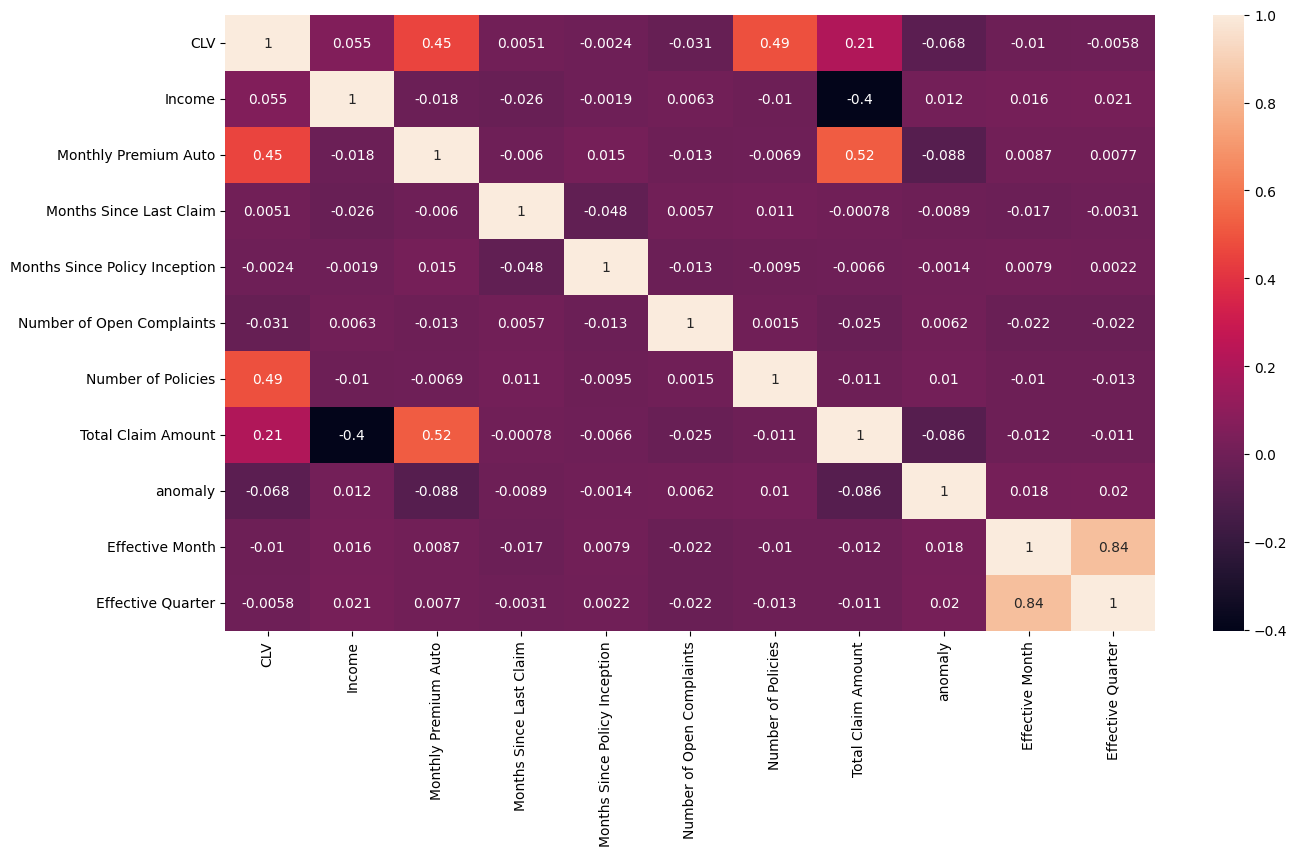

In [236]:
plt.figure(figsize=(15,8))
sns.heatmap(auto_insurance_df_copy_num.corr(method='spearman'), annot=True,fmt='.2g')
plt.show()

In [237]:
# Monthly premium Auto and claim amount have moderate positive correlation
# CLV and number of polices have moderate positive correlation

# CLV and monthly premuim Auto also have moderate postive correlation

# Income and total claim amount have moderate negative relationship 

# Total and CLV have moderate correlation

# Train and Test data spliting

In [238]:
X = auto_insurance_df_copy_new.drop(['CLV'], axis=1)

X_without_anomaly = X.drop(['anomaly'], axis=1)
y = auto_insurance_df_copy_new['CLV']

In [239]:
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state=1)
# splitting the data into train and test data in 80:20 ratio 


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7307, 25)
(1827, 25)
(7307,)
(1827,)


In [240]:
num_col_scaling = ['Income',
 'Monthly Premium Auto',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies',
 'Total Claim Amount']

X_train_num = X_train[num_col_scaling]
X_test_num = X_test[num_col_scaling]

scaler = MinMaxScaler()

X_train_num_scale = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns,index=X_train_num.index)
X_test_num_scale = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns, index=X_test_num.index)


X_train_with_scaling = pd.concat([X_train_num_scale,X_train.drop(num_col_scaling, axis=1)], axis=1)
X_test_with_scaling = pd.concat([X_test_num_scale,X_test.drop(num_col_scaling, axis=1)], axis=1)

# Linear regression Model

In [241]:
X_train_num_scale_with_constant = sm.add_constant(X_train_with_scaling)
X_test_num_scale_with_constant = sm.add_constant(X_test_with_scaling)
model = sm.OLS(y_train, X_train_num_scale_with_constant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CLV   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     57.16
Date:                Fri, 29 Nov 2024   Prob (F-statistic):          3.14e-260
Time:                        13:06:53   Log-Likelihood:                -74314.
No. Observations:                7307   AIC:                         1.487e+05
Df Residuals:                    7281   BIC:                         1.489e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          6669.4989    918.399      7.262      0.000    4869.171    8469.826
Income                           52.9802    365.981      0.145      0.885    -664.449     770.410
Monthly Premium Auto           1.999e+04   1320.278     15.141      0.000    1.74e+04    2.26e+04
Months Since Last Claim          93.5040    258.160      0.362      0.717    -412.564     599.572
Months Since Policy Inception    70.2954    264.176      0.266      0.790    -447.567     588.157
Number of Open Complaints     -1320.8205    408.737     -3.231      0.001   -2122.064    -519.577
Number of Policies              468.5597    248.955      1.882      0.060     -19.465     956.584
Total Claim Amount            -2540.5084   1185.119     -2.144      0.032   -4863.686    -217.331
anomaly                        -525.0786    721.772     -0.727      0.467   -1939.961     889.803
Effective Month                -194.3654    110.572     -1.758      0.079    -411.118      22.387
Effective Quarter               517.6107    358.005      1.446      0.148    -184.183    1219.405
State                            44.7391     57.630      0.776      0.438     -68.232     157.711
Response                       -339.3105    215.795     -1.572      0.116    -762.331      83.710
Coverage                       -135.7058    162.102     -0.837      0.403    -453.472     182.060
Education                      -179.6945     69.501     -2.585      0.010    -315.937     -43.452
EmploymentStatus               -161.3529     81.653     -1.976      0.048    -321.416      -1.290
Gender                          -63.0081    149.412     -0.422      0.673    -355.900     229.884
Location Code                    25.0213    131.760      0.190      0.849    -233.266     283.308
Marital Status                   70.4475    103.382      0.681      0.496    -132.212     273.107
Policy Type                     629.9798    326.435      1.930      0.054      -9.927    1269.887
Policy                          -95.3599     96.585     -0.987      0.324    -284.695      93.975
Renew Offer Type               -289.9836     77.651     -3.734      0.000    -442.201    -137.766
Sales Channel                    29.0933     70.056      0.415      0.678    -108.237     166.423
Vehicle Class                   -20.3066    150.844     -0.135      0.893    -316.005     275.391
Vehicle Size                   -220.5935    139.683     -1.579      0.114    -494.413      53.226
Effective Day                    39.3628     36.632      1.075      0.283     -32.446     111.172
==============================================================================
Omnibus:                     4497.377   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49903.946
Skew

In [242]:
# Model performance is 0.164 r-squared and r2-squared as 0.161.
# We can see the conditional number is very high means there is multi collinearity in the dataset.
# There is no autocorrelation as Durbin-Watson as 2.012.
# residuals is not normally distributed.

##### Assumption 1 - No Auto correlation.

Test needed : Durbin- Watson Test.

It's value ranges from 0-4. If the value of Durbin- Watson is Between 0-2, it's known as Positive Autocorrelation. If the value ranges from 2-4, it is known as Negative autocorrelation. If the value is exactly 2, it means No Autocorrelation. For a good linear model, it should have low or no autocorrelation. we can see here the values of dublin watson test: 1.995 (No AUTO-CORRELATION)

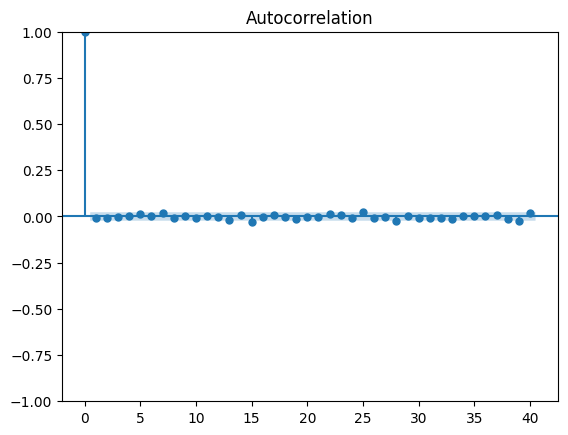

In [243]:
acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)#auto_correlation value, lags= previous value
acf

##### Assumption 2- Normality of Residuals 2) The second assumption is the Normality of Residuals / Error terms.

For this we prefer the Jarque Bera test. For a good model, the residuals should be normally distributed. The higher the value of Jarque Bera test , the lesser the residuals are normally distributed. We generally prefer a lower value of jarque bera test.

The Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. A large value for the jarque-bera test indicates non normality.

The jarque bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution. Note that this test generally works good for large enough number of data samples(>2000) as the test statistics asymptotically has a chi squared distribution with degrees 2 of freedom.

In [244]:
print(stats.jarque_bera(model.resid))

SignificanceResult(statistic=49903.94602425244, pvalue=0.0)


The critical chi square value at the 5% level of significance is 5.99. If the computed value exceeds this value the null hypothesis is rejected. In this case the computed value of the JB statistic 65051.11 is greater than 5.99. Thus we reject the null hypothesis that the error terms are normally distributed.

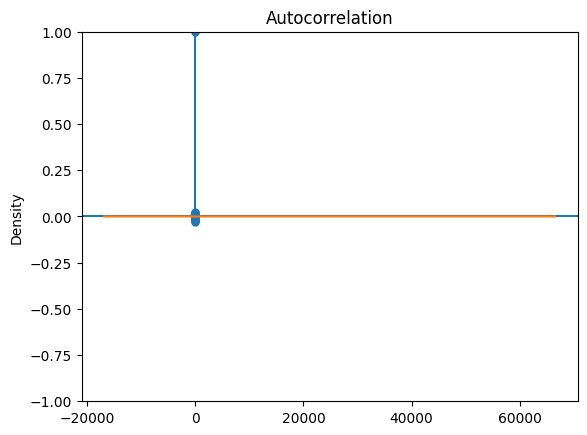

In [245]:
sns.kdeplot(model.resid)
plt.show()

From the graph we infer that due to the high value of Jarque Bera test, only few residuals are normally distributed

##### Asssumption 3 - Linearity of residuals
Here we have 2 options. Either we can plot the observed values Vs predicted values and plot the Residual Vs predicted values and see the linearity of residuals. OR We can go for rainbow test. Let's look both of them one by one.

In [246]:
sm.stats.diagnostic.linear_rainbow(res=model, frac=0.5)#the fraction of the data to include in the center model

(1.0029439048165047, 0.4646863075768991)

In [247]:
model.resid.mean()

-7.368562521548837e-12

H0:The data is linear, pvalue > 0.05 failed to reject H0, here we failed to reject H0 so residuals are normally distributed

##### Assumption 4 - Homoscedasticity_test(using goldfeld test) OR (Beusch-Wagon Test) Homoscedacity :: If the variance of the residuals are symmetrically distributed across the regression line , then the data is said to homoscedastic.

Heteroscedacity :: If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case the residuals can form an arrow shape or any other non symmetrical shape.

This test is based on the hytpothesis testing where null and alternate hypothesis are: 𝐻0:𝜎𝑢𝑖 𝑖𝑠 𝑐𝑜𝑛𝑠𝑡𝑎𝑛𝑡 𝑎𝑐𝑟𝑜𝑠𝑠 𝑡ℎ𝑒 𝑟𝑎𝑛𝑔𝑒 𝑜𝑓 𝑑𝑎𝑡𝑎 𝐻𝑎:𝜎𝑢𝑖 𝑖𝑠 𝑛𝑜𝑡 𝑐𝑜𝑛𝑠𝑡𝑎𝑛𝑡 𝑎𝑐𝑟𝑜𝑠𝑠 𝑡ℎ𝑒 𝑟𝑎𝑛𝑔𝑒 𝑜𝑓 𝑑𝑎𝑡𝑎 The residuals should be homoscedastic.

In [248]:
name=['F-statistic','p-value']
test=sms.het_goldfeldquandt(model.resid,model.model.exog)

test

(1.0068124181247926, 0.41900355371915715, 'increasing')

p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.

##### Assumption 5- NO MULTI COLLINEARITY

The interpretation of VIF is as follows: the square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1

In [249]:
vif = [variance_inflation_factor(X_train_num_scale_with_constant.values, i) for i in range(X_train_num_scale_with_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X_train_with_scaling.columns).sort_values('vif',ascending=False)

,vif
Effective Quarter,24.9014242
Effective Month,24.7919207
Monthly Premium Auto,6.7765770
Policy Type,4.4443660
Policy,4.4407392
Vehicle Class,4.3363080
Total Claim Amount,2.6673854
Income,2.2525665
EmploymentStatus,2.2066307
Coverage,2.0680490


In [250]:
# Monthly Premium Auto is 6.77 is have high VIF.

In [251]:
pd.DataFrame({'pvalue': model.pvalues[1:]}, index=X_train_with_scaling.columns).sort_values('pvalue',ascending=False)

,pvalue
Vehicle Class,0.8929159
Income,0.8849028
Location Code,0.8493921
Months Since Policy Inception,0.7901753
Months Since Last Claim,0.7172172
Sales Channel,0.6779449
Gender,0.6732522
Marital Status,0.4956237
anomaly,0.4669519
State,0.4375871


In [252]:
# Vehicle class is having very high pvalue is 0.88
# Income is having very high pvalue is 0.87
# Location Code is having pvalue is 0.85
# Months Since Policy Inception is having 0.81
# Months Since Last Claim is having 0.70

# These are least important/significant variable as per model

# while below columns can be significant 
# Monthly Premium Auto
# Renew Offer Type 
# Number of Open Complaints
# Education
# Total Claim Amount

In [253]:
lr = LinearRegression()
model = lr.fit(X_train_with_scaling,y_train)
print("Training performance: ")
print(model_performance(lr,X_train_with_scaling, y_train))
print()
print("Testing performance: ")
print(model_performance(lr,X_test_with_scaling, y_test))

Training performance: 
Mean Squared Error  39927259.81428994
Root Mean Squared Error  6318.8020869694865
Mean Absolute Error  3916.5540444010444
Mean Absolute Percentage Error  0.5972022837616313
R2 score  0.16405326675471854
Adjusted R2 score  0.16118296482762984
None

Testing performance: 
Mean Squared Error  37619132.16176922
Root Mean Squared Error  6133.443744077973
Mean Absolute Error  3827.86588592027
Mean Absolute Percentage Error  0.6015266108196309
R2 score  0.16306662806967576
Adjusted R2 score  0.151449007693075
None


In [254]:
model_performance_report(model_name='Linear Regression', model=lr, X_train=X_train_with_scaling,y_train=y_train,
                        X_test=X_test_with_scaling, y_test=y_test)

Mean Squared Error  39927259.81428994
Root Mean Squared Error  6318.8020869694865
Mean Absolute Error  3916.5540444010444
Mean Absolute Percentage Error  0.5972022837616313
R2 score  0.16405326675471854
Adjusted R2 score  0.16118296482762984
Mean Squared Error  37619132.16176922
Root Mean Squared Error  6133.443744077973
Mean Absolute Error  3827.86588592027
Mean Absolute Percentage Error  0.6015266108196309
R2 score  0.16306662806967576
Adjusted R2 score  0.151449007693075


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490


In [255]:
# Model performance is not great we need to check and try other model.

In [256]:
ridge=Ridge(alpha=0.1)
ridge.fit(X_train_with_scaling,y_train)
print("Training performance: ")
print(model_performance(ridge,X_train, y_train))
print()
print("Testing performance: ")
print(model_performance(ridge,X_test, y_test))

Training performance: 
Mean Squared Error  12475954701979.988
Root Mean Squared Error  3532131.7503711535
Mean Absolute Error  2930989.6474490524
Mean Absolute Percentage Error  536.001197220835
R2 score  -261204.84346997095
Adjusted R2 score  -262101.71836170962
None

Testing performance: 
Mean Squared Error  12474410817398.203
Root Mean Squared Error  3531913.1950542335
Mean Absolute Error  2926321.6605935
Mean Absolute Percentage Error  538.0303928962248
R2 score  -277524.0280456812
Adjusted R2 score  -281376.40211627644
None


In [257]:
model_performance_report(model_name='Ridge Regression aplha=0.1', model=ridge, X_train=X_train_with_scaling,y_train=y_train,
                        X_test=X_test_with_scaling, y_test=y_test)

Mean Squared Error  39927285.74616642
Root Mean Squared Error  6318.804138930595
Mean Absolute Error  3916.58219316137
Mean Absolute Percentage Error  0.5972651196305799
R2 score  0.1640527238257139
Adjusted R2 score  0.1611824200344274
Mean Squared Error  37616900.66997543
Root Mean Squared Error  6133.261829563077
Mean Absolute Error  3827.697414697574
Mean Absolute Percentage Error  0.6015651050156328
R2 score  0.1631162732859286
Adjusted R2 score  0.1514993420433679


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993


In [258]:
# Model performance is not improved.
# let's adjust alpha value and try to increase.

In [259]:
ridge=Ridge(alpha=1)
ridge.fit(X_train_with_scaling,y_train)
print("Training performance: ")
print(model_performance(ridge,X_train_with_scaling, y_train))
print()
print("Testing performance: ")
print(model_performance(ridge,X_test_with_scaling, y_test))

Training performance: 
Mean Squared Error  39929627.83810695
Root Mean Squared Error  6318.989463364134
Mean Absolute Error  3916.903974080388
Mean Absolute Percentage Error  0.5978185986616423
R2 score  0.1640036880512643
Adjusted R2 score  0.1611332158910228
None

Testing performance: 
Mean Squared Error  37599907.387779
Root Mean Squared Error  6131.876335003748
Mean Absolute Error  3826.5388383018426
Mean Absolute Percentage Error  0.601932497472603
R2 score  0.16349433211268893
Adjusted R2 score  0.15188264877166568
None


In [260]:
model_performance_report(model_name='Ridge Regression aplha=1', model=ridge, X_train=X_train_with_scaling,y_train=y_train,
                        X_test=X_test_with_scaling, y_test=y_test)

Mean Squared Error  39929627.83810695
Root Mean Squared Error  6318.989463364134
Mean Absolute Error  3916.903974080388
Mean Absolute Percentage Error  0.5978185986616423
R2 score  0.1640036880512643
Adjusted R2 score  0.1611332158910228
Mean Squared Error  37599907.387779
Root Mean Squared Error  6131.876335003748
Mean Absolute Error  3826.5388383018426
Mean Absolute Percentage Error  0.601932497472603
R2 score  0.16349433211268893
Adjusted R2 score  0.15188264877166568


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826


In [261]:
# Ridge performance is not improved with increasing alpha value.

In [262]:
lasso=Lasso(alpha=1)
lasso.fit(X_train_with_scaling,y_train)
print("Training performance: ")
print(model_performance(lasso,X_train_with_scaling, y_train))
print()
print("Testing performance: ")
print(model_performance(lasso,X_test_with_scaling, y_test))

Training performance: 
Mean Squared Error  39928328.22558151
Root Mean Squared Error  6318.886628638111
Mean Absolute Error  3915.8643188024766
Mean Absolute Percentage Error  0.5974795354610566
R2 score  0.16403089770327095
Adjusted R2 score  0.1611605189699351
None

Testing performance: 
Mean Squared Error  37603283.12780066
Root Mean Squared Error  6132.151590412672
Mean Absolute Error  3825.9975983135287
Mean Absolute Percentage Error  0.601801870301357
R2 score  0.16341923018139137
Adjusted R2 score  0.15180650433715748
None


In [263]:
model_performance_report(model_name='Lasso Regression', model=lasso, X_train=X_train_with_scaling,y_train=y_train,
                        X_test=X_test_with_scaling, y_test=y_test)

Mean Squared Error  39928328.22558151
Root Mean Squared Error  6318.886628638111
Mean Absolute Error  3915.8643188024766
Mean Absolute Percentage Error  0.5974795354610566
R2 score  0.16403089770327095
Adjusted R2 score  0.1611605189699351
Mean Squared Error  37603283.12780066
Root Mean Squared Error  6132.151590412672
Mean Absolute Error  3825.9975983135287
Mean Absolute Percentage Error  0.601801870301357
R2 score  0.16341923018139137
Adjusted R2 score  0.15180650433715748


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065


In [264]:
#  We didn't improve the performance using Lasso

In [265]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
print("Training performance: ")
print(model_performance(dt,X_train, y_train))
print()
print("Testing performance: ")
print(model_performance(dt,X_test, y_test))

Training performance: 
Mean Squared Error  2.4430808258738234e-26
Root Mean Squared Error  1.563035772422955e-13
Mean Absolute Error  1.4593985737358126e-14
Mean Absolute Percentage Error  1.9650794134785837e-18
R2 score  1.0
Adjusted R2 score  1.0
None

Testing performance: 
Mean Squared Error  29753950.48210658
Root Mean Squared Error  5454.718185397535
Mean Absolute Error  1837.9148106776133
Mean Absolute Percentage Error  0.1373000482136871
R2 score  0.3380476190106184
Adjusted R2 score  0.3288589407625703
None


In [266]:
model_performance_report(model_name='Decision Tree Regression', model=dt, X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

Mean Squared Error  2.4430808258738234e-26
Root Mean Squared Error  1.563035772422955e-13
Mean Absolute Error  1.4593985737358126e-14
Mean Absolute Percentage Error  1.9650794134785837e-18
R2 score  1.0
Adjusted R2 score  1.0
Mean Squared Error  29753950.48210658
Root Mean Squared Error  5454.718185397535
Mean Absolute Error  1837.9148106776133
Mean Absolute Percentage Error  0.1373000482136871
R2 score  0.3380476190106184
Adjusted R2 score  0.3288589407625703


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589


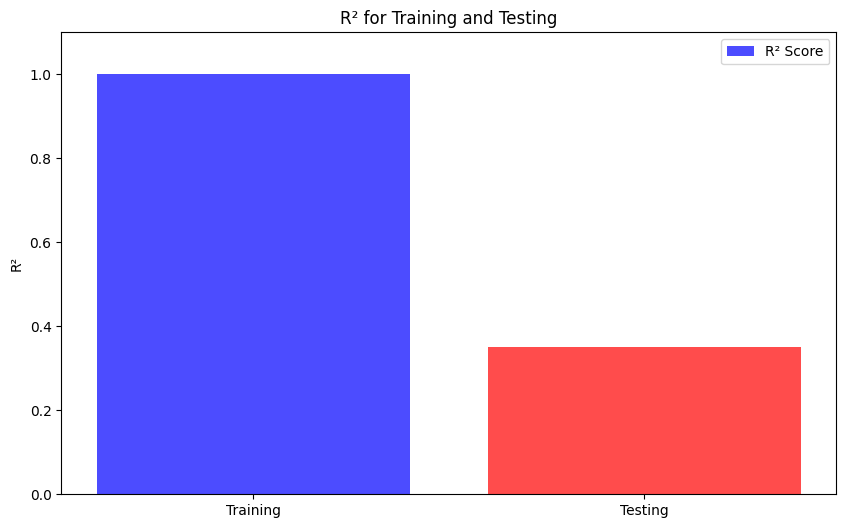

In [267]:
train_and_plot_tree_based_model_r2_comparison(model=dt,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

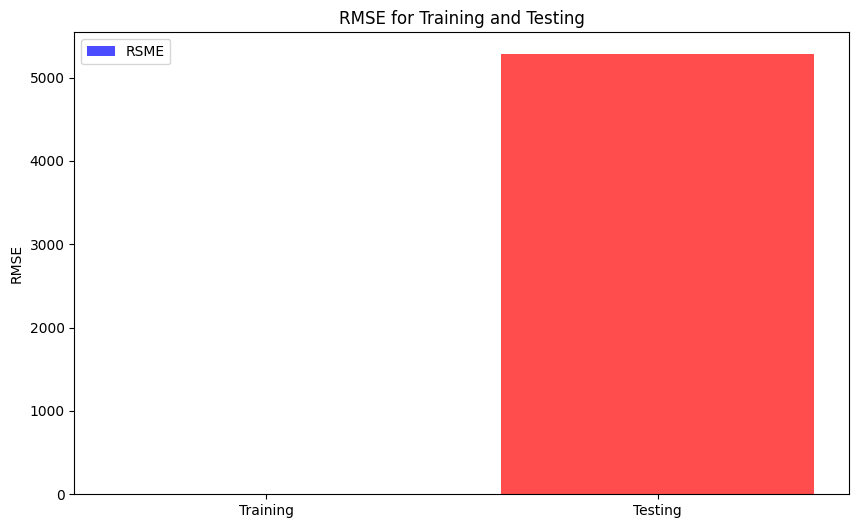

In [268]:
train_and_plot_tree_based_model_rmse_comparison(model=dt,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

In [269]:
#  We improve model performance with decision tree but it is overfitting.

In [270]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("Training performance: ")
print(model_performance(rf,X_train, y_train))
print()
print("Testing performance: ")
print(model_performance(rf,X_test, y_test))

Training performance: 
Mean Squared Error  1973750.1099493727
Root Mean Squared Error  1404.9021709533274
Mean Absolute Error  546.0003010626853
Mean Absolute Percentage Error  0.0394839125934882
R2 score  0.9586761033857831
Adjusted R2 score  0.9585342138904727
None

Testing performance: 
Mean Squared Error  14428428.053247899
Root Mean Squared Error  3798.4770702543274
Mean Absolute Error  1479.3433975888922
Mean Absolute Percentage Error  0.10921449328979312
R2 score  0.6790028836834567
Adjusted R2 score  0.6745470658556314
None


In [271]:
model_performance_report(model_name='Random Forest Regression', model=rf, X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

Mean Squared Error  1973750.1099493727
Root Mean Squared Error  1404.9021709533274
Mean Absolute Error  546.0003010626853
Mean Absolute Percentage Error  0.0394839125934882
R2 score  0.9586761033857831
Adjusted R2 score  0.9585342138904727
Mean Squared Error  14428428.053247899
Root Mean Squared Error  3798.4770702543274
Mean Absolute Error  1479.3433975888922
Mean Absolute Percentage Error  0.10921449328979312
R2 score  0.6790028836834567
Adjusted R2 score  0.6745470658556314


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471


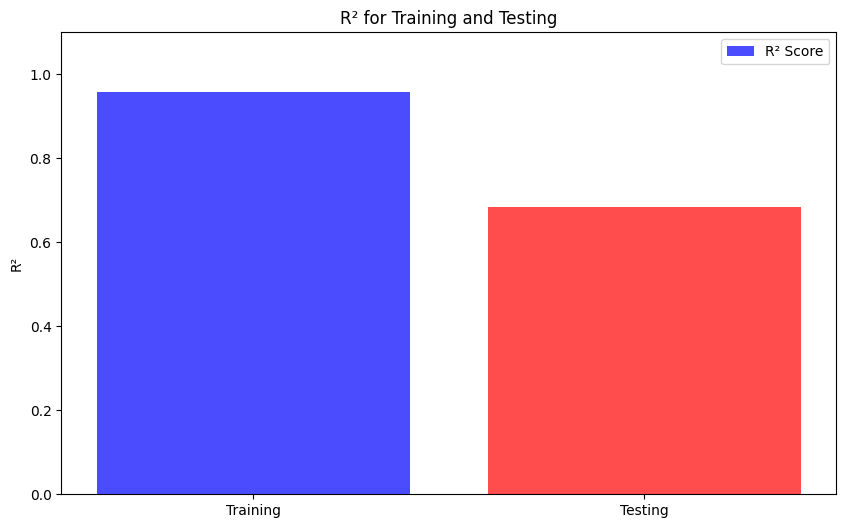

In [272]:
train_and_plot_tree_based_model_r2_comparison(model=rf,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

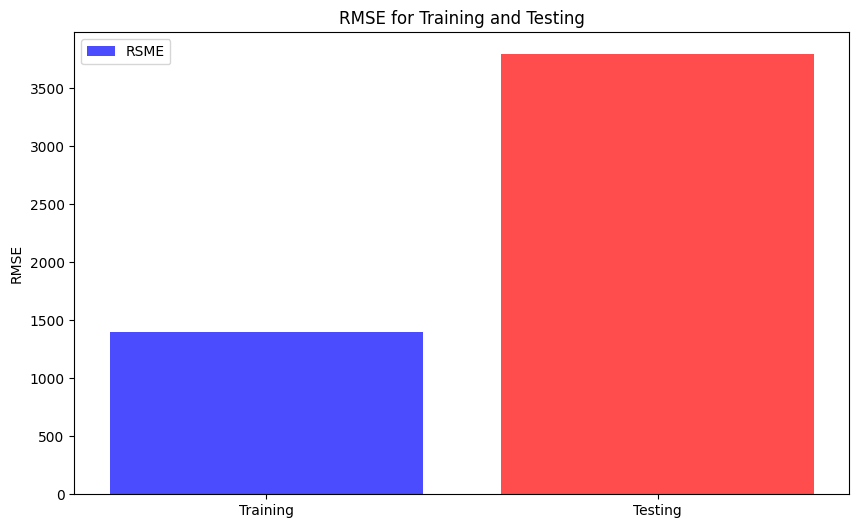

In [273]:
train_and_plot_tree_based_model_rmse_comparison(model=rf,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

In [274]:
# We able to improve the performance with random forest significant but model is overfitting.

In [275]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)
print("Training performance: ")
print(model_performance(ada,X_train, y_train))
print()
print("Testing performance: ")
print(model_performance(ada,X_test, y_test))

Training performance: 
Mean Squared Error  42675135.110982895
Root Mean Squared Error  6532.6208454940115
Mean Absolute Error  5163.750454067261
Mean Absolute Percentage Error  0.7134575816752003
R2 score  0.10652171091241758
Adjusted R2 score  0.10345386896389541
None

Testing performance: 
Mean Squared Error  43892387.97918856
Root Mean Squared Error  6625.133053697002
Mean Absolute Error  5192.523617155983
Mean Absolute Percentage Error  0.7187077168493367
R2 score  0.023502080921776414
Adjusted R2 score  0.009947140346009853
None


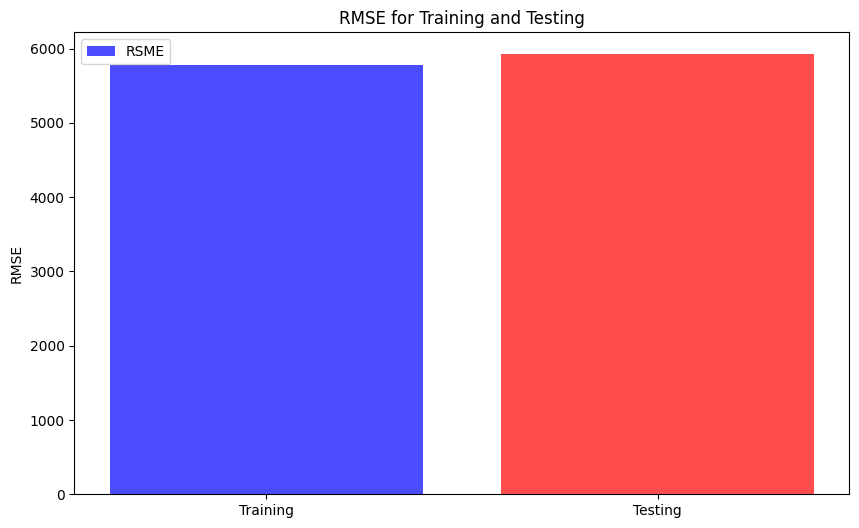

In [276]:
train_and_plot_tree_based_model_rmse_comparison(model=ada,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

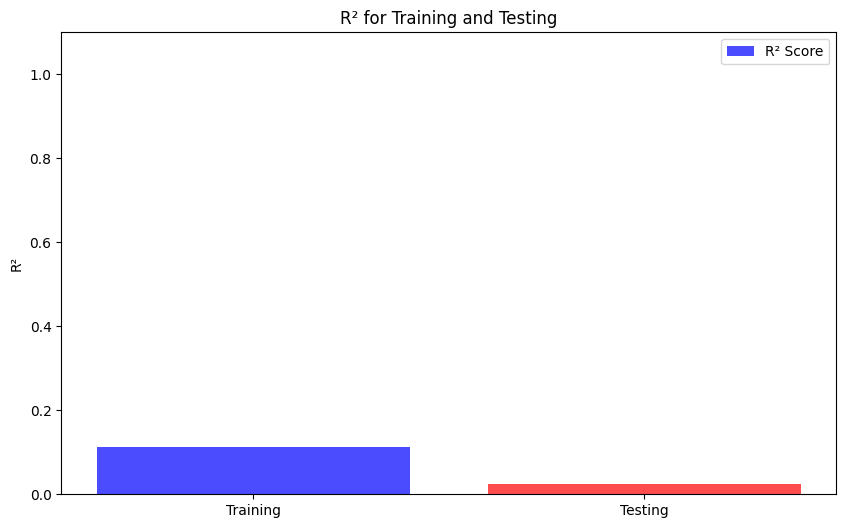

In [277]:
train_and_plot_tree_based_model_r2_comparison(model=ada,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

In [278]:
model_performance_report(model_name='AdaBoost Regression', model=ada, X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

Mean Squared Error  42365029.92334956
Root Mean Squared Error  6508.842441121889
Mean Absolute Error  5496.972984563975
Mean Absolute Percentage Error  0.8299189367439027
R2 score  0.1130143031857227
Adjusted R2 score  0.10996875416493479
Mean Squared Error  43842940.68534083
Root Mean Squared Error  6621.400205797927
Mean Absolute Error  5515.219159039988
Mean Absolute Percentage Error  0.8269473625367849
R2 score  0.024602161864496153
Adjusted R2 score  0.011062491707146016


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625


In [279]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
print("Training performance: ")
print(model_performance(gbr,X_train, y_train))
print()
print("Testing performance: ")
print(model_performance(gbr,X_test, y_test))

Training performance: 
Mean Squared Error  12640404.42569352
Root Mean Squared Error  3555.3346432781145
Mean Absolute Error  1630.7787391631257
Mean Absolute Percentage Error  0.13421213692443204
R2 score  0.7353511151101866
Adjusted R2 score  0.7344424182111006
None

Testing performance: 
Mean Squared Error  14539085.94689171
Root Mean Squared Error  3813.0153352552506
Mean Absolute Error  1712.316420589077
Mean Absolute Percentage Error  0.1474788236052631
R2 score  0.676541017108232
Adjusted R2 score  0.6720510256744208
None


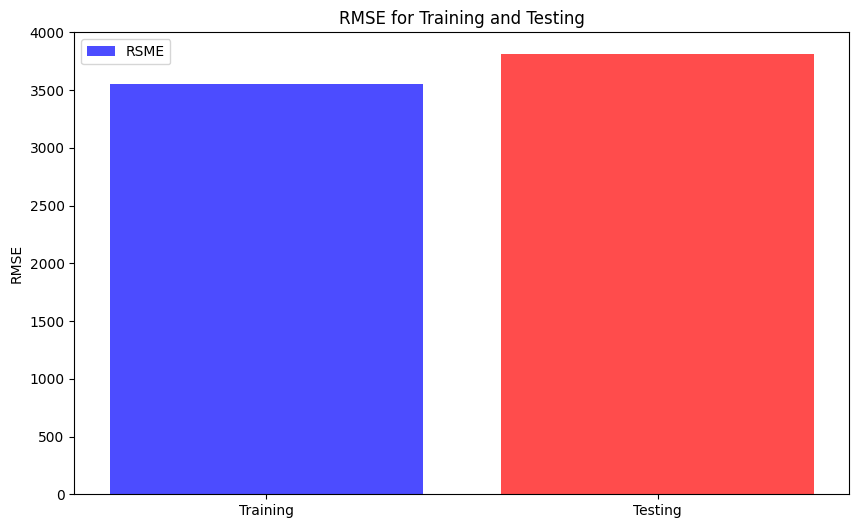

In [280]:
train_and_plot_tree_based_model_rmse_comparison(model=gbr,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

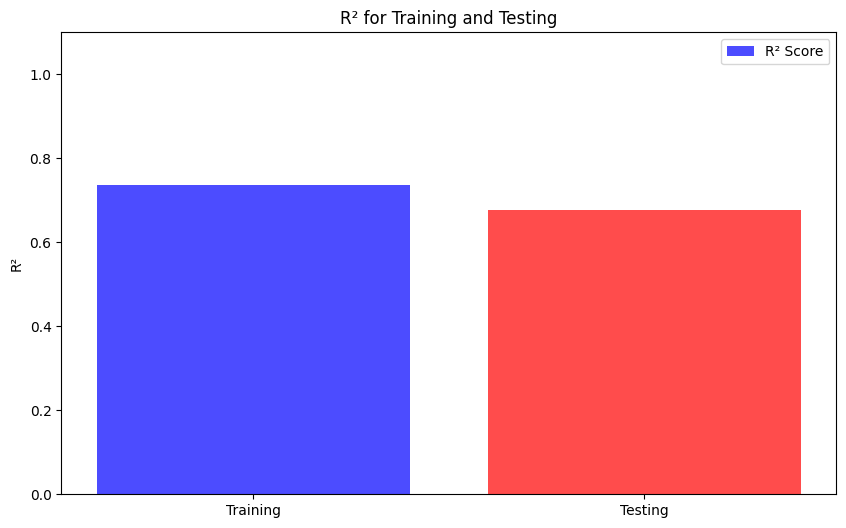

In [281]:
train_and_plot_tree_based_model_r2_comparison(model=gbr,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

In [282]:
model_performance_report(model_name='Gradient Boost Regression', model=gbr, X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

Mean Squared Error  12640404.42569352
Root Mean Squared Error  3555.3346432781145
Mean Absolute Error  1630.7787391631257
Mean Absolute Percentage Error  0.134212136924432
R2 score  0.7353511151101866
Adjusted R2 score  0.7344424182111006
Mean Squared Error  14515707.606997076
Root Mean Squared Error  3809.948504507256
Mean Absolute Error  1710.3901855496374
Mean Absolute Percentage Error  0.14684757436645346
R2 score  0.6770611277996219
Adjusted R2 score  0.6725783561144418


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784


In [283]:
# We able to balance the performance with gradient boosting but now model is underftting.

In [284]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
print("Training performance: ")
print(model_performance(xgbr,X_train, y_train))
print()
print("Testing performance: ")
print(model_performance(xgbr,X_test, y_test))

Training performance: 
Mean Squared Error  2119300.0573066548
Root Mean Squared Error  1455.7815967055824
Mean Absolute Error  793.7133987561677
Mean Absolute Percentage Error  0.09839937292748101
R2 score  0.9556287617053557
Adjusted R2 score  0.9554764088750624
None

Testing performance: 
Mean Squared Error  15571752.452029243
Root Mean Squared Error  3946.1059859093043
Mean Absolute Error  1906.852391491223
Mean Absolute Percentage Error  0.21001809440515326
R2 score  0.653566721568725
Adjusted R2 score  0.6487578198692348
None


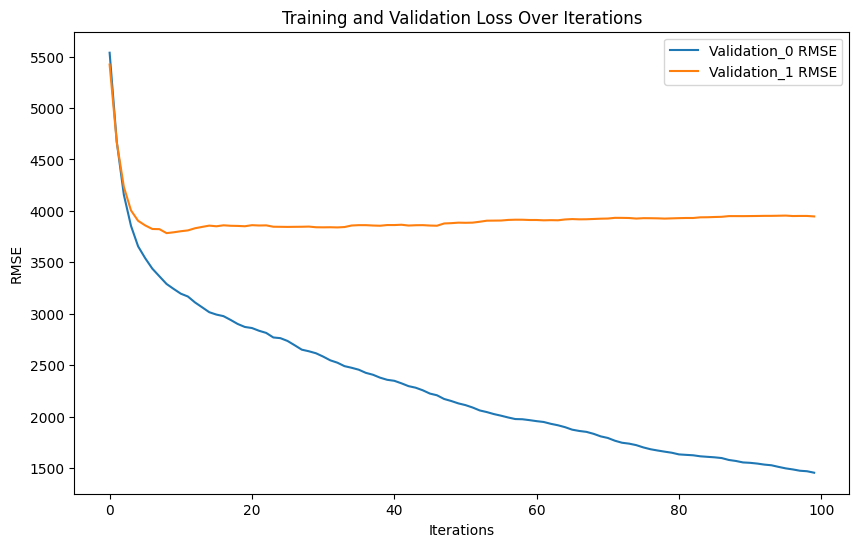

In [285]:
train_and_evaluate_xgb_rmse(model=xgbr,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test , eval_metric='rmse')

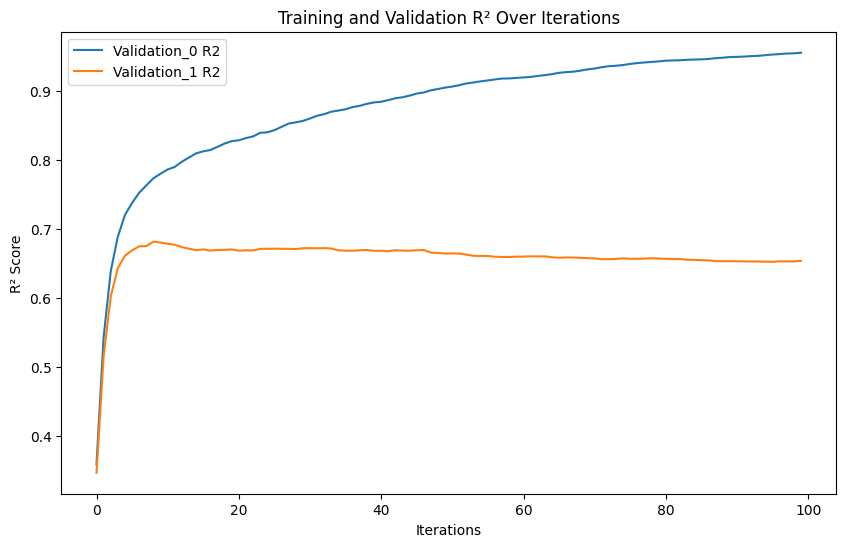

In [286]:
train_and_evaluate_xgb_r2(model=xgbr,X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

In [287]:
model_performance_report(model_name='Xtreme Gradient Boost Regression', model=xgbr, X_train=X_train,y_train=y_train,
                        X_test=X_test, y_test=y_test)

Mean Squared Error  30656729.54182673
Root Mean Squared Error  5536.851952312499
Mean Absolute Error  3285.9866929156847
Mean Absolute Percentage Error  0.5389795997164518
R2 score  0.35814796628487544
Adjusted R2 score  0.35594410680913335
Mean Squared Error  29395859.082914438
Root Mean Squared Error  5421.794821174482
Mean Absolute Error  3261.759823390326
Mean Absolute Percentage Error  0.5501315707865617
R2 score  0.34601427387379724
Adjusted R2 score  0.3369361821729894


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362


In [288]:
# we didn't able to improve the performance with Xgb boost.

# we need to tranform the target variable CLV which was right skewed heavily.

# Transformation of target variable

In [289]:
# using log transformation

In [290]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [291]:
lr = LinearRegression()
model = lr.fit(X_train_with_scaling,y_train_log)
print("Training performance: ")
print(model_performance(lr,X_train_with_scaling, y_train_log))
print()
print("Testing performance: ")
print(model_performance(lr,X_test_with_scaling, y_test_log))

Training performance: 
Mean Squared Error  0.3216900365792404
Root Mean Squared Error  0.5671772532279837
Mean Absolute Error  0.4396761661537498
Mean Absolute Percentage Error  0.04953649550398074
R2 score  0.2477758939031851
Adjusted R2 score  0.24519306151032416
None

Testing performance: 
Mean Squared Error  0.31411702409610004
Root Mean Squared Error  0.560461438545151
Mean Absolute Error  0.4365932689282388
Mean Absolute Percentage Error  0.049339938476330183
R2 score  0.2527916185053686
Adjusted R2 score  0.2424194866134387
None


In [292]:
model_performance_report(model_name='Linear Regression with log transformation on target variable', model=lr, X_train=X_train_with_scaling,y_train=y_train_log,
                        X_test=X_test_with_scaling, y_test=y_test_log)

Mean Squared Error  0.3216900365792404
Root Mean Squared Error  0.5671772532279837
Mean Absolute Error  0.4396761661537498
Mean Absolute Percentage Error  0.04953649550398074
R2 score  0.2477758939031851
Adjusted R2 score  0.24519306151032416
Mean Squared Error  0.31411702409610004
Root Mean Squared Error  0.560461438545151
Mean Absolute Error  0.4365932689282388
Mean Absolute Percentage Error  0.049339938476330183
R2 score  0.2527916185053686
Adjusted R2 score  0.2424194866134387


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [293]:
# we able to improve the performance using log transformation let try out other model as well
# Let try to see which are factor influencing CLV

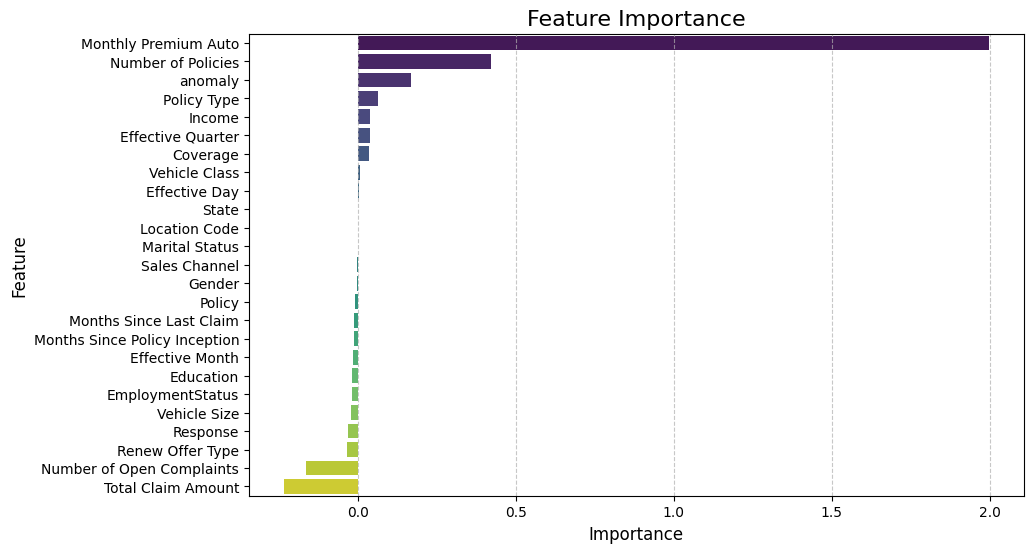

In [294]:
get_feature_importance_with_plot(model=lr, feature_names=X_train_with_scaling.columns)

In [295]:
# Below are top 3 feature impacting CLV positively
# policy type
# Number of policies
# Coverage

# Below are top 3 feature impacing CLV negatively

# Renew Offer Type
# Number of open compliants
# Renew Offer Type

In [296]:
ridge=Ridge(alpha=1)
ridge.fit(X_train_with_scaling,y_train_log)
print("Training performance: ")
print(model_performance(ridge,X_train_with_scaling, y_train_log))
print()
print("Testing performance: ")
print(model_performance(ridge,X_test_with_scaling, y_test_log))

Training performance: 
Mean Squared Error  0.32171373715953794
Root Mean Squared Error  0.5671981462941659
Mean Absolute Error  0.4396972698569956
Mean Absolute Percentage Error  0.04954210886885675
R2 score  0.2477204736358437
Adjusted R2 score  0.24513745095226958
None

Testing performance: 
Mean Squared Error  0.3139441076584412
Root Mean Squared Error  0.5603071547450035
Mean Absolute Error  0.43640544365168654
Mean Absolute Percentage Error  0.04932269750910392
R2 score  0.2532029448633992
Adjusted R2 score  0.24283652266550082
None


In [297]:
model_performance_report(model_name='Ridge Regression with log transformation on target variable', model=ridge, X_train=X_train_with_scaling,y_train=y_train_log,
                        X_test=X_test_with_scaling, y_test=y_test_log)

Mean Squared Error  0.32171373715953794
Root Mean Squared Error  0.5671981462941659
Mean Absolute Error  0.4396972698569956
Mean Absolute Percentage Error  0.04954210886885675
R2 score  0.2477204736358437
Adjusted R2 score  0.24513745095226958
Mean Squared Error  0.3139441076584412
Root Mean Squared Error  0.5603071547450035
Mean Absolute Error  0.43640544365168654
Mean Absolute Percentage Error  0.04932269750910392
R2 score  0.2532029448633992
Adjusted R2 score  0.24283652266550082


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [298]:
# we able to improve performance but not significant with Ridge

In [299]:
lasso=Lasso()
lasso.fit(X_train_with_scaling,y_train_log)
print("Training performance: ")
print(model_performance(lasso,X_train_with_scaling, y_train_log))
print()
print("Testing performance: ")
print(model_performance(lasso,X_test_with_scaling, y_test_log))

Training performance: 
Mean Squared Error  0.42765185796616484
Root Mean Squared Error  0.6539509599092006
Mean Absolute Error  0.5213122443832285
Mean Absolute Percentage Error  0.059336373284157286
R2 score  0.0
Adjusted R2 score  -0.003433594286499142
None

Testing performance: 
Mean Squared Error  0.42074690898647027
Root Mean Squared Error  0.6486500666665118
Mean Absolute Error  0.519298869656242
Mean Absolute Percentage Error  0.059295366296883964
R2 score  -0.0008550723645821545
Adjusted R2 score  -0.014748118899348572
None


In [300]:
model_performance_report(model_name='Lasso Regression with log transformation on target variable', model=lasso, X_train=X_train_with_scaling,y_train=y_train_log,
                        X_test=X_test_with_scaling, y_test=y_test_log)

Mean Squared Error  0.42765185796616484
Root Mean Squared Error  0.6539509599092006
Mean Absolute Error  0.5213122443832285
Mean Absolute Percentage Error  0.059336373284157286
R2 score  0.0
Adjusted R2 score  -0.003433594286499142
Mean Squared Error  0.42074690898647027
Root Mean Squared Error  0.6486500666665118
Mean Absolute Error  0.519298869656242
Mean Absolute Percentage Error  0.059295366296883964
R2 score  -0.0008550723645821545
Adjusted R2 score  -0.014748118899348572


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [301]:
# performance of Lasso model is not good at all. we will not going use linear model for further experiments.

In [302]:
knn=KNeighborsRegressor()
knn.fit(X_train_with_scaling,y_train_log)
print("Training performance: ")
print(model_performance(knn,X_train_with_scaling, y_train_log))
print()
print("Testing performance: ")
print(model_performance(knn,X_test_with_scaling, y_test_log))

Training performance: 
Mean Squared Error  0.26503936599287503
Root Mean Squared Error  0.5148197412618081
Mean Absolute Error  0.3954447561840314
Mean Absolute Percentage Error  0.044788878083695124
R2 score  0.38024502628527224
Adjusted R2 score  0.3781170391484959
None

Testing performance: 
Mean Squared Error  0.39072506059254636
Root Mean Squared Error  0.625080043348487
Mean Absolute Error  0.4870696833279347
Mean Absolute Percentage Error  0.05535060056275465
R2 score  0.070559639437342
Adjusted R2 score  0.0576579131663445
None


In [303]:
# KNN and linear model are not good model so we are not doing any experiment with these model.

In [304]:
dt=DecisionTreeRegressor()
dt.fit(X_train,y_train_log)
print("Training performance: ")
print(model_performance(dt,X_train, y_train_log))
print()
print("Testing performance: ")
print(model_performance(dt,X_test, y_test_log))

Training performance: 
Mean Squared Error  2.666602485145613e-32
Root Mean Squared Error  1.63297351024002e-16
Mean Absolute Error  1.6895689111580322e-17
Mean Absolute Percentage Error  1.9513031951139865e-18
R2 score  1.0
Adjusted R2 score  1.0
None

Testing performance: 
Mean Squared Error  0.07682452884705342
Root Mean Squared Error  0.27717238110434705
Mean Absolute Error  0.11437292643126164
Mean Absolute Percentage Error  0.012161728202017039
R2 score  0.8172530380227581
Adjusted R2 score  0.814716295074712
None


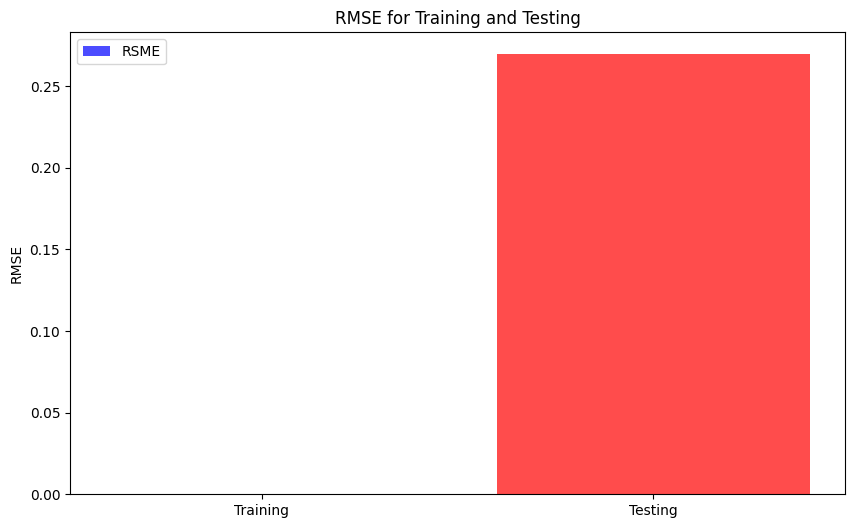

In [305]:
train_and_plot_tree_based_model_rmse_comparison(model=dt,X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

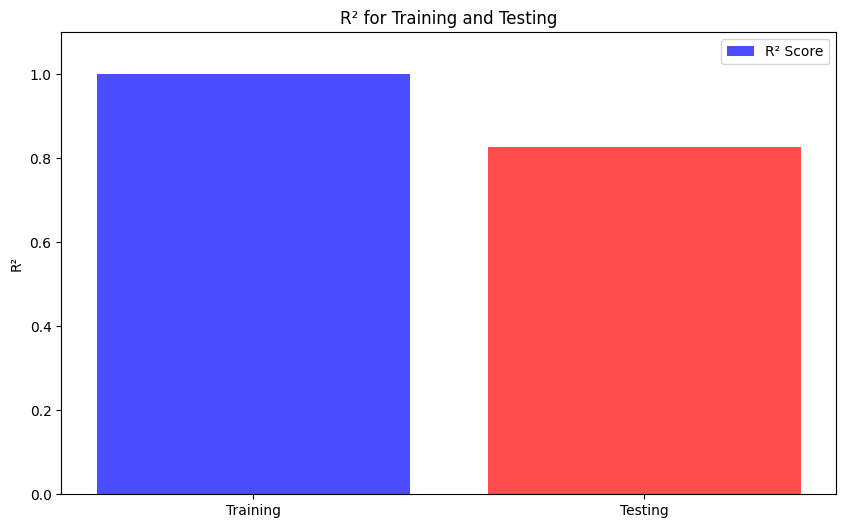

In [306]:
train_and_plot_tree_based_model_r2_comparison(model=dt,X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

In [307]:
model_performance_report(model_name='Decision Tree Regression with log transformation on target variable', model=dt, X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

Mean Squared Error  2.3535196022742655e-32
Root Mean Squared Error  1.5341185098532203e-16
Mean Absolute Error  1.482930986771798e-17
Mean Absolute Percentage Error  1.7270231709872377e-18
R2 score  1.0
Adjusted R2 score  1.0
Mean Squared Error  0.07313360009342551
Root Mean Squared Error  0.27043224677065697
Mean Absolute Error  0.11154619959691234
Mean Absolute Percentage Error  0.01185439420219671
R2 score  0.8260328642933856
Adjusted R2 score  0.8236179956689185


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [308]:
# we able to improve performance significant using log tranformation with decision tree
# Now cheking which feature is impact the decision tree model

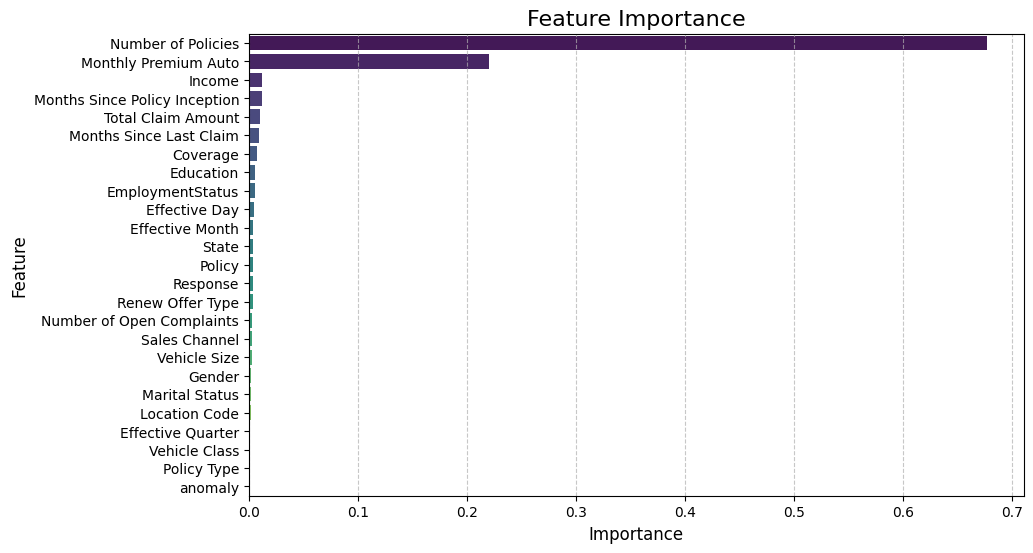

In [309]:
get_feature_importance_with_plot(model=dt, feature_names=X_train_with_scaling.columns)

In [310]:
# Number of Policies is most importance feature followed by Monthly Premium Auto and other features are
# not significant impacting but Months Since Policy Inception, Income, Total Claim Amount are top 5 features.

# Location Code, Vehicle Class and Policy Type are least significant features.

In [311]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train_log)
print("Training performance: ")
print(model_performance(rf,X_train, y_train_log))
print()
print("Testing performance: ")
print(model_performance(rf,X_test, y_test_log))

Training performance: 
Mean Squared Error  0.005326010439311339
Root Mean Squared Error  0.072979520684308
Mean Absolute Error  0.03391126771661104
Mean Absolute Percentage Error  0.003587492093319766
R2 score  0.9875459200279384
Adjusted R2 score  0.9875031577701027
None

Testing performance: 
Mean Squared Error  0.039038777792781615
Root Mean Squared Error  0.19758233168171088
Mean Absolute Error  0.09216822574478466
Mean Absolute Percentage Error  0.00977465902803917
R2 score  0.9071361953271635
Adjusted R2 score  0.905847136406108
None


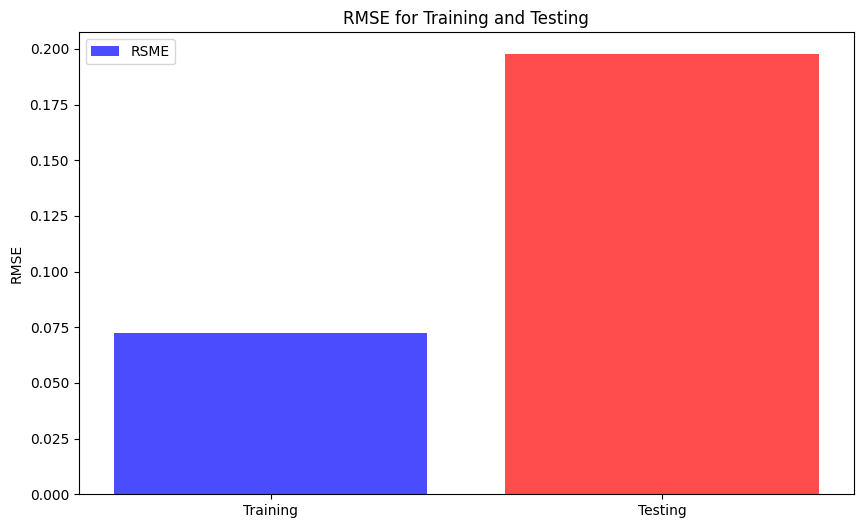

In [312]:
train_and_plot_tree_based_model_rmse_comparison(model=rf,X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

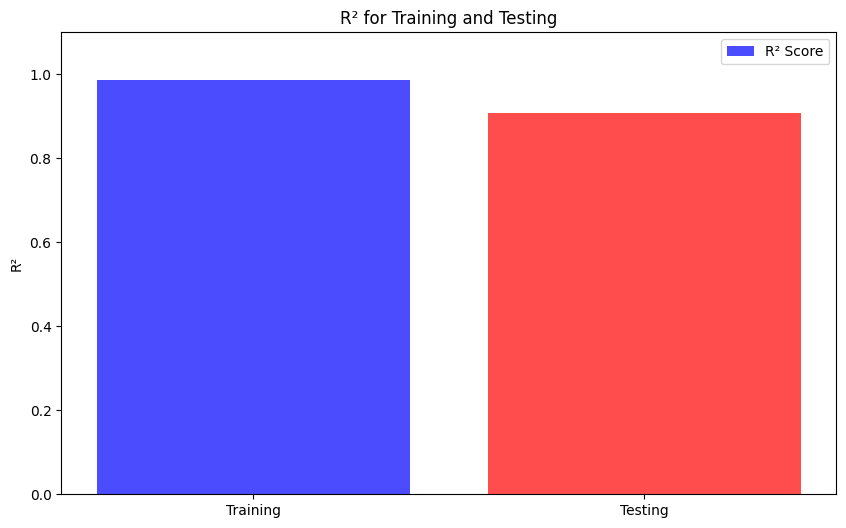

In [313]:
train_and_plot_tree_based_model_r2_comparison(model=rf,X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

In [314]:
model_performance_report(model_name="Random Forest Regression with log transformation on target variable", model=rf, X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

Mean Squared Error  0.0054224621428551854
Root Mean Squared Error  0.07363736920107335
Mean Absolute Error  0.03415878140884909
Mean Absolute Percentage Error  0.0036131296853767533
R2 score  0.9873203821242741
Adjusted R2 score  0.987276845460781
Mean Squared Error  0.03881314207681114
Root Mean Squared Error  0.1970105126048129
Mean Absolute Error  0.09235479154464632
Mean Absolute Percentage Error  0.009793511272141541
R2 score  0.9076729280898109
Adjusted R2 score  0.9063913196513019


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [315]:
# We are able to improve performance using log transformation and random forest

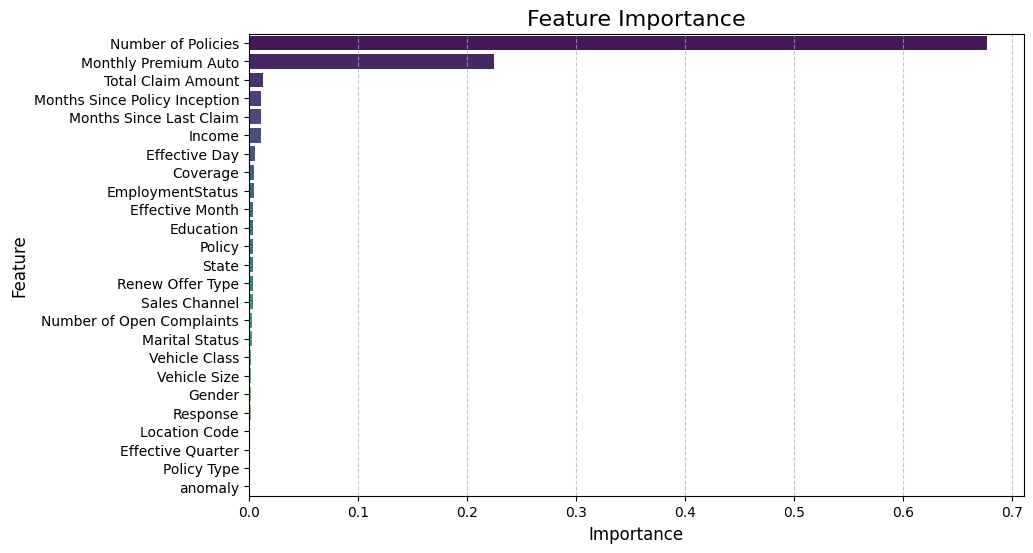

In [316]:
get_feature_importance_with_plot(model=rf, feature_names=X_train_with_scaling.columns)

In [317]:
# Number of Policies is most importance feature followed by Monthly Premium Auto and other features are
# not significant impacting but Total Claim Amount Months Since Policy Inception, and Income,  are top 5 features.

# Gender, Location Code,and Policy Type are least significant features.

In [318]:
gbr=GradientBoostingRegressor()
gbr.fit(X_train,y_train_log)
print("Training performance: ")
print(model_performance(gbr,X_train, y_train_log))
print()
print("Testing performance: ")
print(model_performance(gbr,X_test, y_test_log))

Training performance: 
Mean Squared Error  0.037699689940676434
Root Mean Squared Error  0.19416407994445428
Mean Absolute Error  0.10107515443178887
Mean Absolute Percentage Error  0.01070650308799811
R2 score  0.9118449055267306
Adjusted R2 score  0.9115422166980214
None

Testing performance: 
Mean Squared Error  0.040067816564330144
Root Mean Squared Error  0.20016946961095278
Mean Absolute Error  0.10384102196890316
Mean Absolute Percentage Error  0.01103645505111159
R2 score  0.9046883611252554
Adjusted R2 score  0.9033653233840735
None


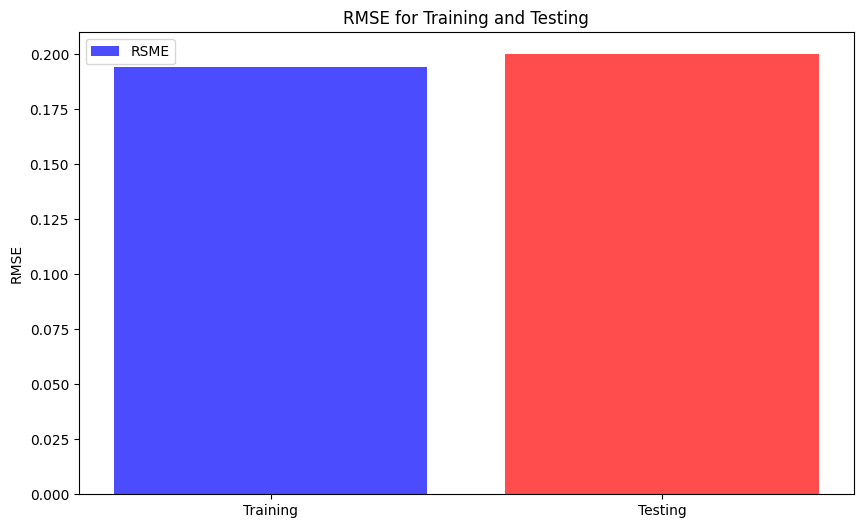

In [319]:
train_and_plot_tree_based_model_rmse_comparison(model=gbr,X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

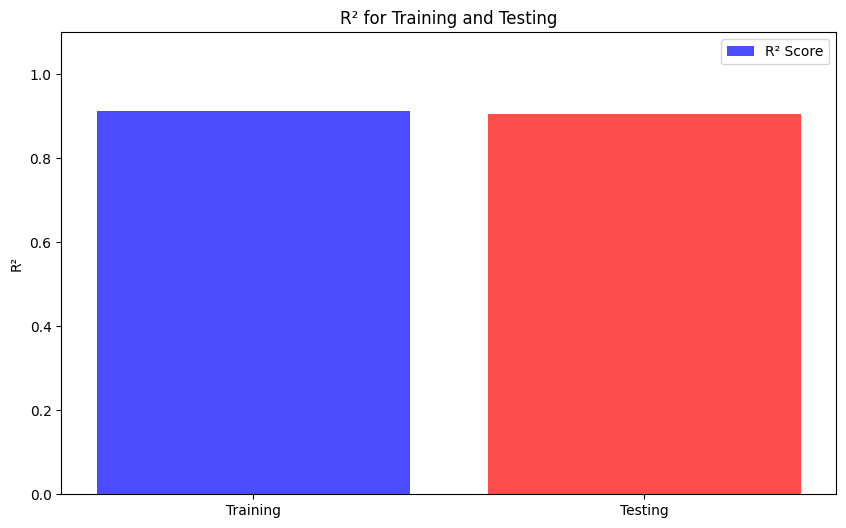

In [320]:
train_and_plot_tree_based_model_r2_comparison(model=gbr,X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

In [321]:
model_performance_report(model_name="Gradient Boost Regression with log transformation on target variable", model=gbr, X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

Mean Squared Error  0.03769968994067643
Root Mean Squared Error  0.19416407994445425
Mean Absolute Error  0.10107515443178879
Mean Absolute Percentage Error  0.010706503087998101
R2 score  0.9118449055267307
Adjusted R2 score  0.9115422166980215
Mean Squared Error  0.040044933711757005
Root Mean Squared Error  0.20011230274962358
Mean Absolute Error  0.10380870309026824
Mean Absolute Percentage Error  0.011032650404957097
R2 score  0.9047427938936938
Adjusted R2 score  0.903420511743412


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [322]:
# We are able to improve performance using log transformation and gradient boosting and train and 
# test performance are closer than random forest.

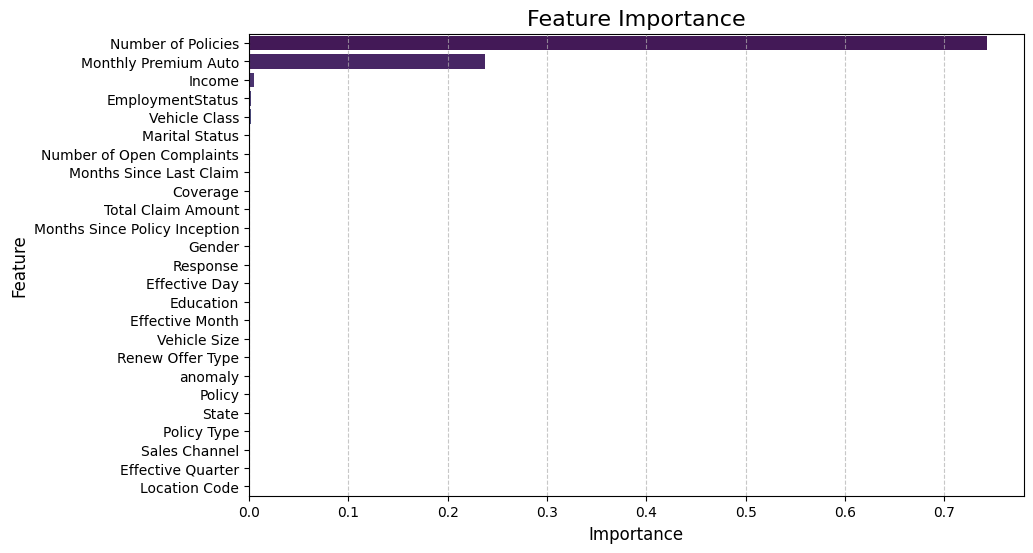

In [323]:
get_feature_importance_with_plot(model=gbr, feature_names=X_train_with_scaling.columns)

In [324]:
# Number of Policies is most importance feature followed by Monthly Premium Auto and other features are
# not significant impacting but Income,EmploymentStatus,Vehicle Class  are top 5 features.

# Coverage, Sales Channel  and Location Code are least significant features.

In [325]:
xgbr=XGBRegressor()
xgbr.fit(X_train,y_train_log)
print("Training performance: ")
print(model_performance(xgbr,X_train, y_train_log))
print()
print("Testing performance: ")
print(model_performance(xgbr,X_test, y_test_log))

Training performance: 
Mean Squared Error  0.006808867947631884
Root Mean Squared Error  0.08251586482387423
Mean Absolute Error  0.0465633158848452
Mean Absolute Percentage Error  0.005090083801306866
R2 score  0.9840784792096692
Adjusted R2 score  0.9840238111668511
None

Testing performance: 
Mean Squared Error  0.04223382051910031
Root Mean Squared Error  0.2055086872107851
Mean Absolute Error  0.11181660028619604
Mean Absolute Percentage Error  0.012082407615777318
R2 score  0.8995359619071231
Adjusted R2 score  0.8981414027997817
None


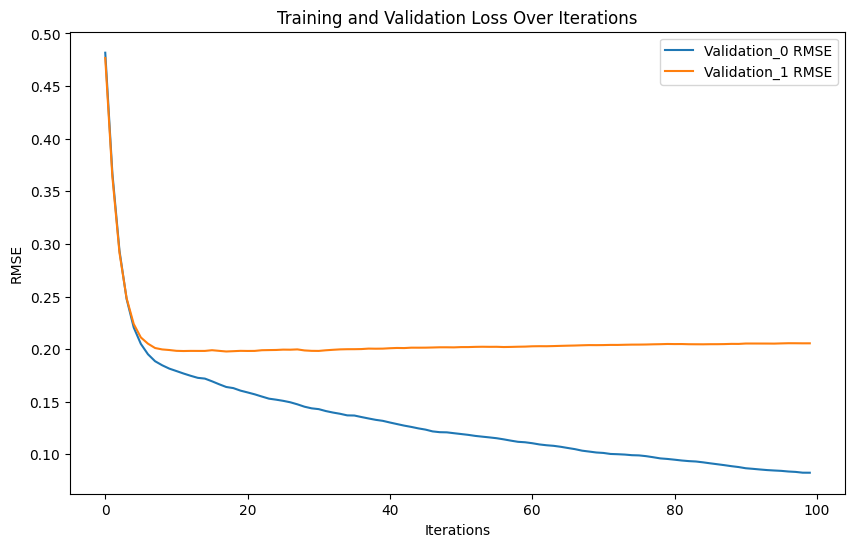

In [326]:
train_and_evaluate_xgb_rmse(model=xgbr,X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log , eval_metric='rmse')

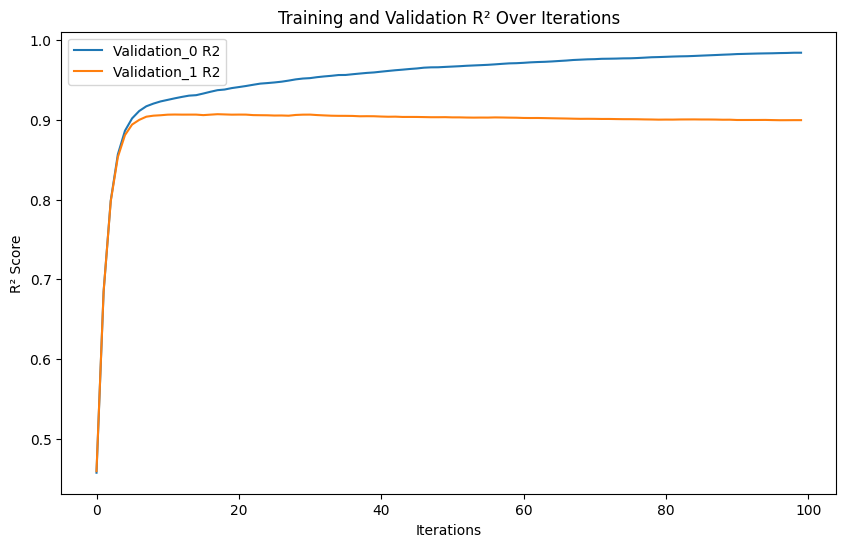

In [327]:
train_and_evaluate_xgb_r2(model=xgbr,X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

In [328]:
model_performance_report(model_name="Xtreme Gradient Boost Regression with log transformation on target variable", model=xgbr, X_train=X_train,y_train=y_train_log,
                        X_test=X_test, y_test=y_test_log)

Mean Squared Error  0.23203813947709698
Root Mean Squared Error  0.481703372914387
Mean Absolute Error  0.36812435195658405
Mean Absolute Percentage Error  0.041772533740493535
R2 score  0.45741346575546626
Adjusted R2 score  0.45555044373155285
Mean Squared Error  0.22725294421272546
Root Mean Squared Error  0.4767105455228838
Mean Absolute Error  0.3651273779924602
Mean Absolute Percentage Error  0.04156972784523433
R2 score  0.4594202427464402
Adjusted R2 score  0.4519163593864519


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [329]:
# We are able to decrease performance using log transformation and XG boosting and train and 
# test performance are become slightly worsen

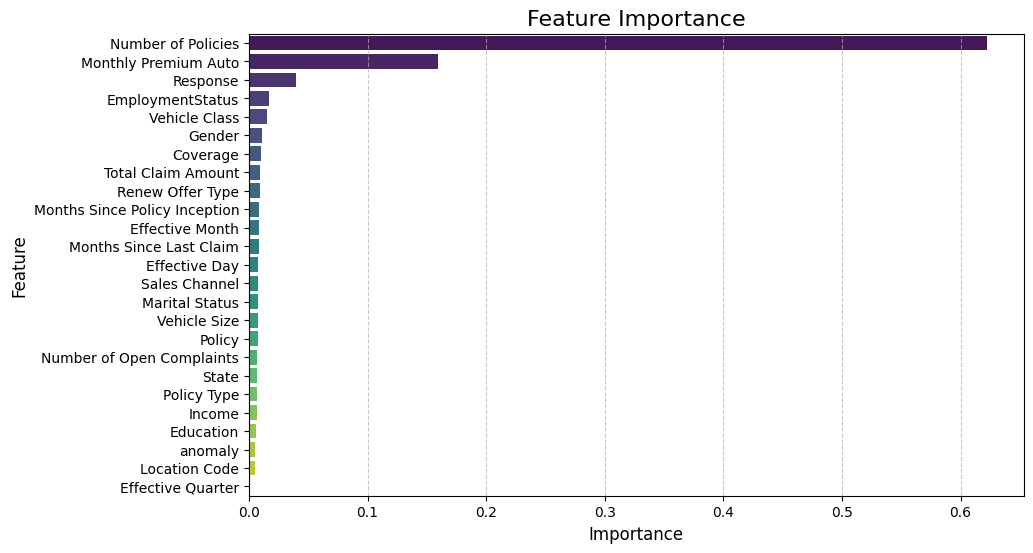

In [330]:
get_feature_importance_with_plot(model=xgbr, feature_names=X_train_with_scaling.columns)

In [331]:
# Number of Policies is most importance feature followed by Monthly Premium Auto and other features are
# not significant impacting but Reponse,EmploymentStatus and Vehicle Class  are top 5 features.

# Income, Number of Open Complaints and Location Code are least significant features.

In [332]:
# we able to improve the model performance significantly using log transformation.

#### Let try to use other transformation

In [333]:
# {'yeo-johnson', 'box-cox'}
pow_transform = PowerTransformer(method='box-cox', standardize=True)
y_train_transformed = pow_transform.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pow_transform.fit_transform(y_test.values.reshape(-1,1))

In [334]:
%%time
rf=RandomForestRegressor()
rf.fit(X_train,y_train_transformed)
print("Training performance: ")
print(model_performance(rf,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(rf,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.007382127011975961
Root Mean Squared Error  0.08591930523448127
Mean Absolute Error  0.042342276936211024
Mean Absolute Percentage Error  0.1276976522140841
R2 score  0.9926178729880241
Adjusted R2 score  0.9925925257588936
None

Testing performance: 
Mean Squared Error  0.051381333113732844
Root Mean Squared Error  0.22667450918383578
Mean Absolute Error  0.12231221068555374
Mean Absolute Percentage Error  0.3974102668228948
R2 score  0.9486186668862672
Adjusted R2 score  0.9479054335004574
None
CPU times: total: 4.05 s
Wall time: 4.06 s


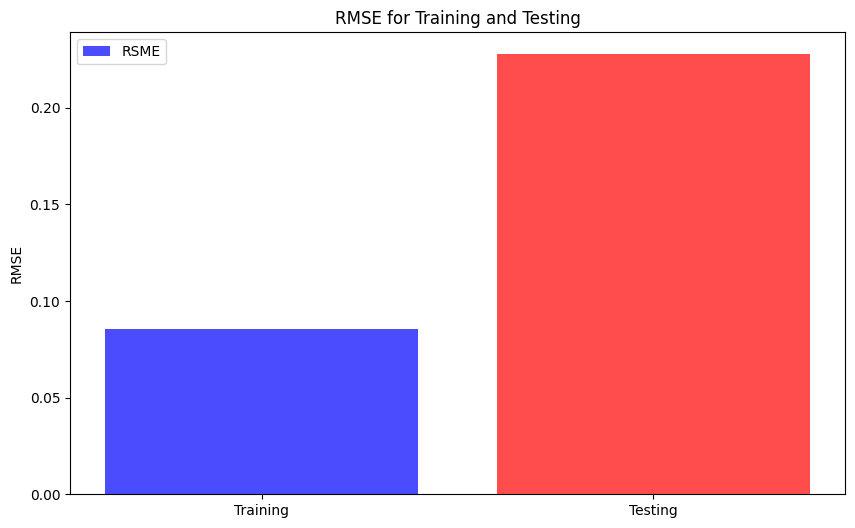

In [335]:
train_and_plot_tree_based_model_rmse_comparison(model=rf,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

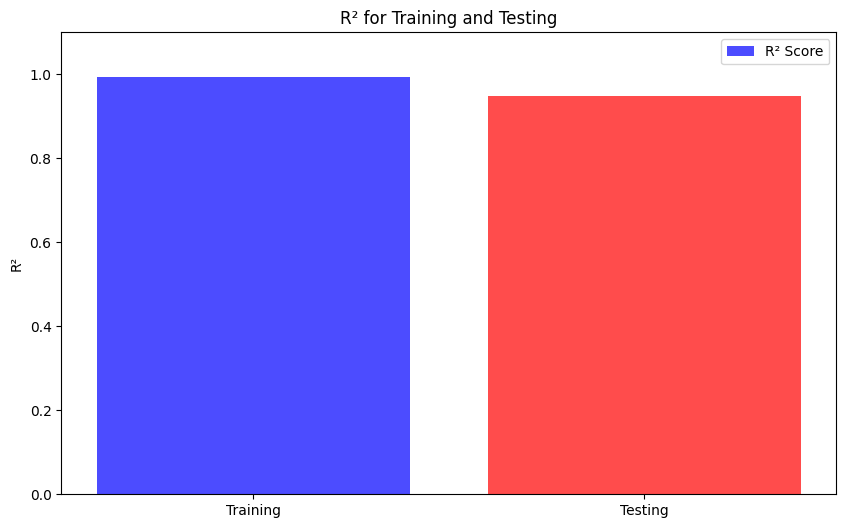

In [336]:
train_and_plot_tree_based_model_r2_comparison(model=rf,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

In [337]:
model_performance_report(model_name="Random Forest Regression with box-cox transformation on target variable", 
                         model=rf, X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

Mean Squared Error  0.007353948857417991
Root Mean Squared Error  0.08575516810908827
Mean Absolute Error  0.04221407657404549
Mean Absolute Percentage Error  0.1353133081653713
R2 score  0.992646051142582
Adjusted R2 score  0.9926208006658019
Mean Squared Error  0.05200769516289334
Root Mean Squared Error  0.22805195715646323
Mean Absolute Error  0.12269700320488024
Mean Absolute Percentage Error  0.4048730461610663
R2 score  0.9479923048371067
Adjusted R2 score  0.9472703768087489


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [338]:
# We able to improve the model performance using power transformers compare to log transformation
# Model is still getting overfitted on train data

In [339]:
%%time
gbr=GradientBoostingRegressor()
gbr.fit(X_train,y_train_transformed)
print("Training performance: ")
print(model_performance(gbr,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(gbr,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.052329163023683775
Root Mean Squared Error  0.22875568413415168
Mean Absolute Error  0.12457533980864004
Mean Absolute Percentage Error  0.43942342786327343
R2 score  0.9476708369763163
Adjusted R2 score  0.9474911598611409
None

Testing performance: 
Mean Squared Error  0.05383955326344988
Root Mean Squared Error  0.23203351754315557
Mean Absolute Error  0.1309915247946563
Mean Absolute Percentage Error  0.42763206738106146
R2 score  0.9461604467365501
Adjusted R2 score  0.9454130903614328
None
CPU times: total: 1.11 s
Wall time: 1.12 s


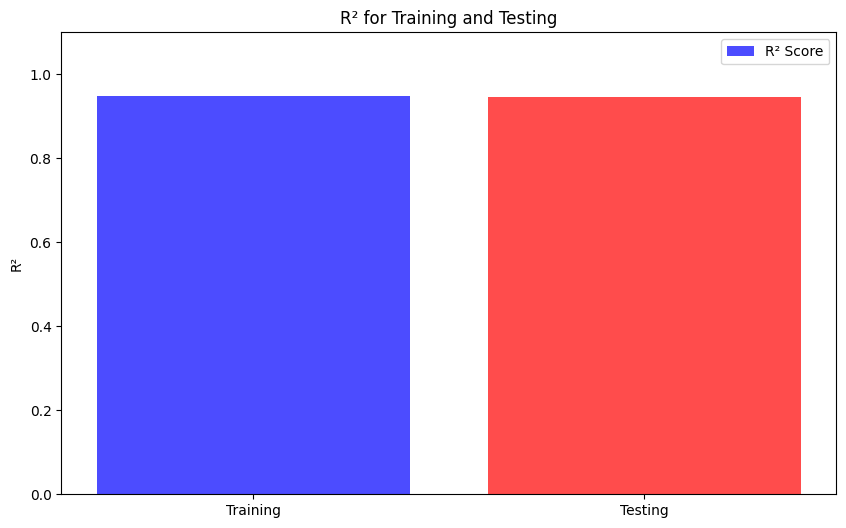

In [340]:
train_and_plot_tree_based_model_r2_comparison(model=gbr,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

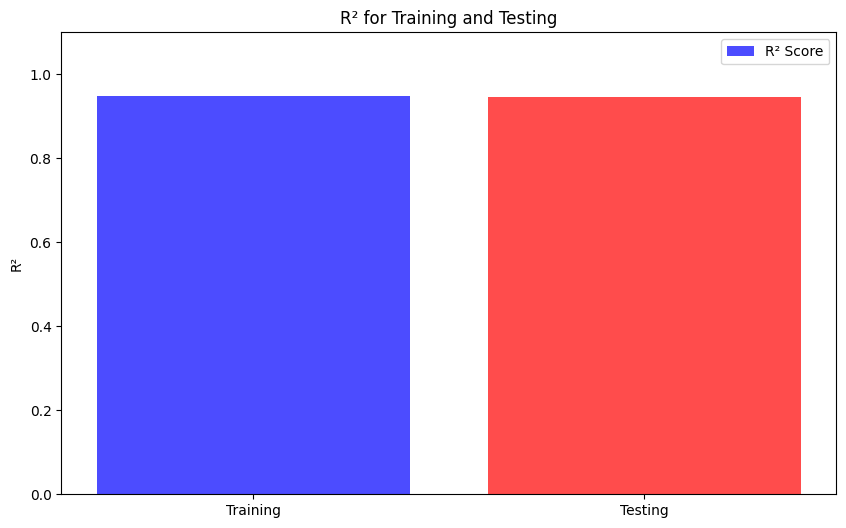

In [341]:
train_and_plot_tree_based_model_r2_comparison(model=gbr,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

In [342]:
model_performance_report(model_name="Gradient Boosting Regression with box-cox transformation on target variable", 
                         model=gbr, X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

Mean Squared Error  0.052329163023683775
Root Mean Squared Error  0.22875568413415168
Mean Absolute Error  0.12457533980864004
Mean Absolute Percentage Error  0.4394234278632739
R2 score  0.9476708369763163
Adjusted R2 score  0.9474911598611409
Mean Squared Error  0.053822191564693714
Root Mean Squared Error  0.23199610247737723
Mean Absolute Error  0.13094951096661195
Mean Absolute Percentage Error  0.4274647793123041
R2 score  0.9461778084353063
Adjusted R2 score  0.9454306930610046


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [343]:
%%time
xgbr=XGBRegressor()
xgbr.fit(X_train,y_train_transformed)
print("Training performance: ")
print(model_performance(xgbr,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(xgbr,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.009635080932237788
Root Mean Squared Error  0.09815844809407791
Mean Absolute Error  0.0563563786407309
Mean Absolute Percentage Error  0.3159471078506075
R2 score  0.9903649190677623
Adjusted R2 score  0.9903318361089234
None

Testing performance: 
Mean Squared Error  0.05792921150891933
Root Mean Squared Error  0.2406848801003489
Mean Absolute Error  0.13669342516316163
Mean Absolute Percentage Error  0.6611658805156893
R2 score  0.9420707884910807
Adjusted R2 score  0.9412666628454822
None
CPU times: total: 1.38 s
Wall time: 142 ms


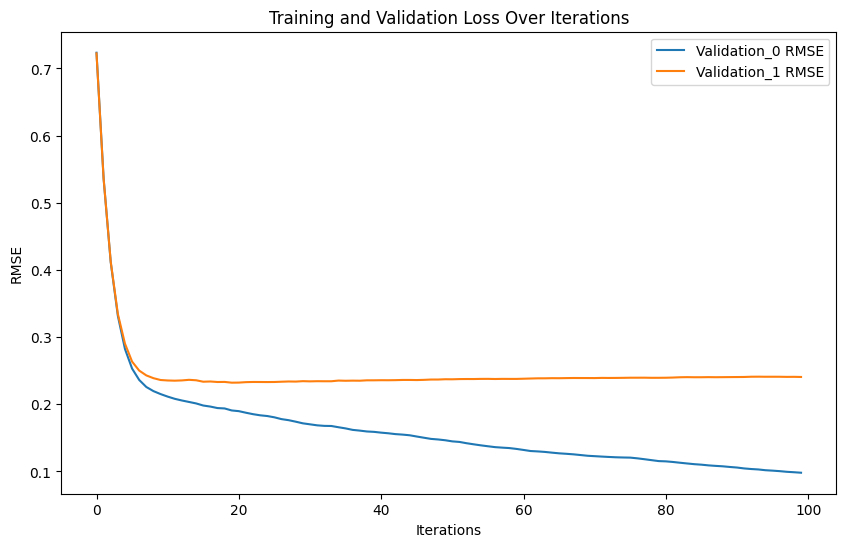

In [344]:
train_and_evaluate_xgb_rmse(model=xgbr,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed , eval_metric='rmse')

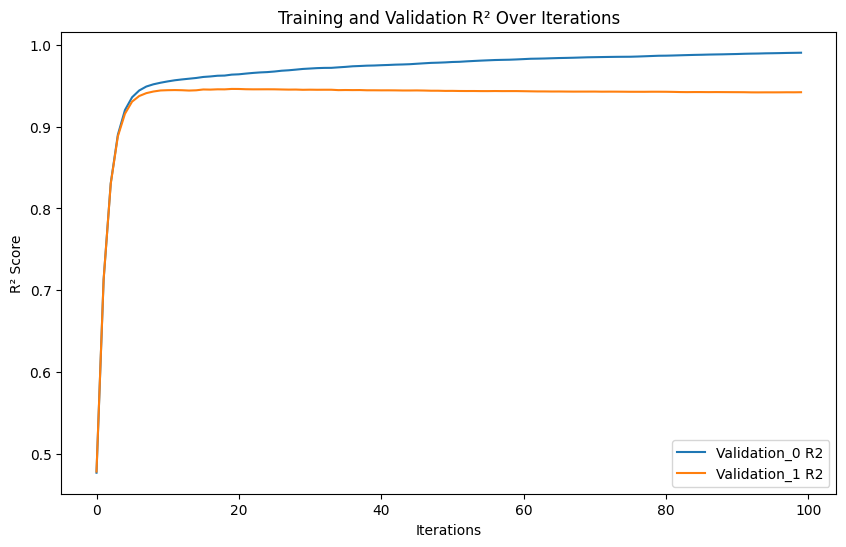

In [345]:
train_and_evaluate_xgb_r2(model=xgbr,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

In [346]:
model_performance_report(model_name="Xtreme Gradient Boosting Regression with box-cox transformation on target variable", 
                         model=xgbr, X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

Mean Squared Error  0.5232095695096661
Root Mean Squared Error  0.7233322677094297
Mean Absolute Error  0.5716674840328847
Mean Absolute Percentage Error  0.7537207502475956
R2 score  0.476790430490334
Adjusted R2 score  0.4749939411018239
Mean Squared Error  0.5217595074513686
Root Mean Squared Error  0.7223292237279124
Mean Absolute Error  0.5708005234077301
Mean Absolute Percentage Error  0.7953166832831403
R2 score  0.47824049254863166
Adjusted R2 score  0.4709978564096621


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [347]:
# We able to improve XG boost performance using box-cox power transformation but model is overfitting

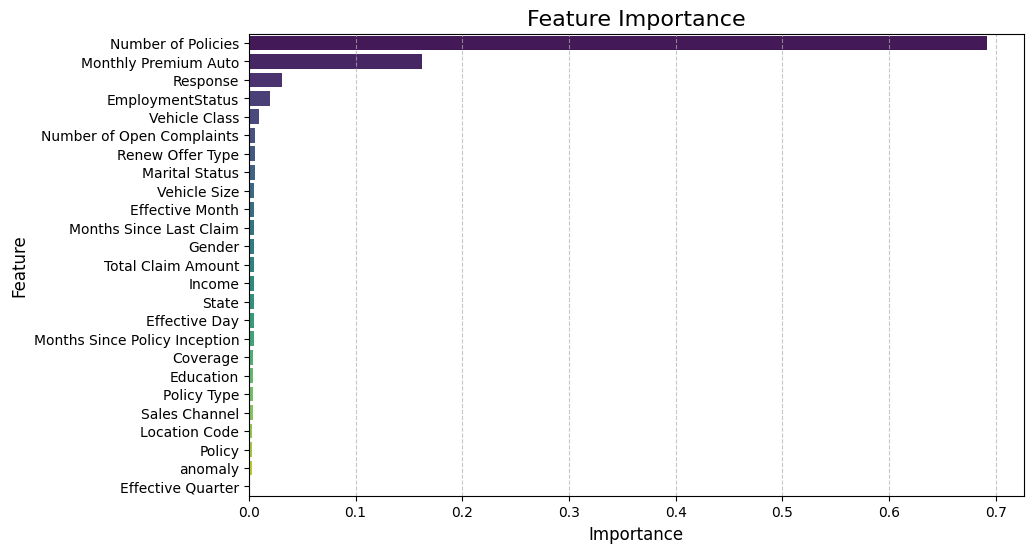

In [348]:
get_feature_importance_with_plot(model=xgbr, feature_names=X_train_with_scaling.columns)

In [349]:
X_signi_columns = get_feature_importance_with_plot(model=xgbr, feature_names=X_train_with_scaling.columns,get_plot=False, return_df=True)['Feature'].values.tolist()

X_signi_columns

['Number of Policies',
 'Monthly Premium Auto',
 'Response',
 'EmploymentStatus',
 'Vehicle Class',
 'Number of Open Complaints',
 'Renew Offer Type',
 'Marital Status',
 'Vehicle Size',
 'Effective Month',
 'Months Since Last Claim',
 'Gender',
 'Total Claim Amount',
 'Income',
 'State',
 'Effective Day',
 'Months Since Policy Inception',
 'Coverage',
 'Education',
 'Policy Type',
 'Sales Channel',
 'Location Code',
 'Policy',
 'anomaly',
 'Effective Quarter']

In [350]:
X_signi_columns_new = X_signi_columns[:-21]
print(X_signi_columns_new)
print()
X_train_signi = X_train[X_signi_columns_new] 
X_test_signi = X_test[X_signi_columns_new]

xgbr=XGBRegressor()
xgbr.fit(X_train_signi,y_train_transformed)
print("Training performance: ")
print(model_performance(xgbr,X_train_signi, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(xgbr,X_test_signi, y_test_transformed))

['Number of Policies', 'Monthly Premium Auto', 'Response', 'EmploymentStatus']

Training performance: 
Mean Squared Error  0.044569517998647036
Root Mean Squared Error  0.21111494025446667
Mean Absolute Error  0.10960814720325851
Mean Absolute Percentage Error  0.4062100898857269
R2 score  0.9554304820013529
Adjusted R2 score  0.9554060670366865
None

Testing performance: 
Mean Squared Error  0.05613061070470311
Root Mean Squared Error  0.2369189960824229
Mean Absolute Error  0.1341283888234095
Mean Absolute Percentage Error  0.47193091717934055
R2 score  0.943869389295297
Adjusted R2 score  0.9437461607317301
None


In [351]:
%%time
X_signi_columns_new = X_signi_columns[:-18]
print(X_signi_columns_new)
print()
X_train_signi = X_train[X_signi_columns_new] 
X_test_signi = X_test[X_signi_columns_new]

xgbr=XGBRegressor(max_depth=2)
xgbr.fit(X_train_signi,y_train_transformed)
print("Training performance: ")
print(model_performance(xgbr,X_train_signi, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(xgbr,X_test_signi, y_test_transformed))

['Number of Policies', 'Monthly Premium Auto', 'Response', 'EmploymentStatus', 'Vehicle Class', 'Number of Open Complaints', 'Renew Offer Type']

Training performance: 
Mean Squared Error  0.05751238002577057
Root Mean Squared Error  0.23981738891450421
Mean Absolute Error  0.1406606594797909
Mean Absolute Percentage Error  0.5341337038433407
R2 score  0.9424876199742295
Adjusted R2 score  0.9424324635609975
None

Testing performance: 
Mean Squared Error  0.05730967656381906
Root Mean Squared Error  0.23939439543109411
Mean Absolute Error  0.14588428546279797
Mean Absolute Percentage Error  0.4258142708977172
R2 score  0.942690323436181
Adjusted R2 score  0.9424697804257649
None
CPU times: total: 641 ms
Wall time: 49 ms


In [352]:
%%time
lgbm = LGBMRegressor()
lgbm.fit(X_train,y_train_transformed)
print("Training performance: ")
print(model_performance(lgbm,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(lgbm,X_test, y_test_transformed))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
Training performance: 
Mean Squared Error  0.02513527825858054
Root Mean Squared Error  0.1585410932805137
Mean Absolute Error  0.08327469048066861
Mean Absolute Percentage Error  0.251985985965706
R2 score  0.9748647217414195
Adjusted R2 score  0.9747784173936013
None

Testing performance: 
Mean Squared Error  0.05268245757636626
Root Mean Squared Error  0.22952659448605572
Mean Absolute Error  0.12172160828840833
Mean Absolute Percentage Error  0.34934642694390666
R2 score  0.9473175424236338
Adjusted R2 sco

In [353]:
model_performance_report(model_name="Light Gradient Boosting Machine Regression with box-cox transformation on target variable", 
                         model=lgbm, X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

Mean Squared Error  0.02513527825858054
Root Mean Squared Error  0.1585410932805137
Mean Absolute Error  0.08327469048066861
Mean Absolute Percentage Error  0.251985985965706
R2 score  0.9748647217414195
Adjusted R2 score  0.9747784173936013
Mean Squared Error  0.05268245757636626
Root Mean Squared Error  0.22952659448605572
Mean Absolute Error  0.12172160828840833
Mean Absolute Percentage Error  0.34934642694390666
R2 score  0.9473175424236338
Adjusted R2 score  0.946586247898698


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [354]:
# we able to get better performance with Light GBM model with best overall test score and gap between test and train score is far less.

In [355]:
%%time
bgr = BaggingRegressor()
bgr.fit(X_train,y_train_transformed)
print("Training performance: ")
print(model_performance(bgr,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(bgr,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.009823959909735062
Root Mean Squared Error  0.09911589130777698
Mean Absolute Error  0.044362651397281086
Mean Absolute Percentage Error  0.12863423161422863
R2 score  0.9901760400902649
Adjusted R2 score  0.9901423085976481
None

Testing performance: 
Mean Squared Error  0.0591264840636367
Root Mean Squared Error  0.24315937996227227
Mean Absolute Error  0.12964466627861543
Mean Absolute Percentage Error  0.387421493026714
R2 score  0.9408735159363633
Adjusted R2 score  0.9400527707383672
None
CPU times: total: 969 ms
Wall time: 456 ms


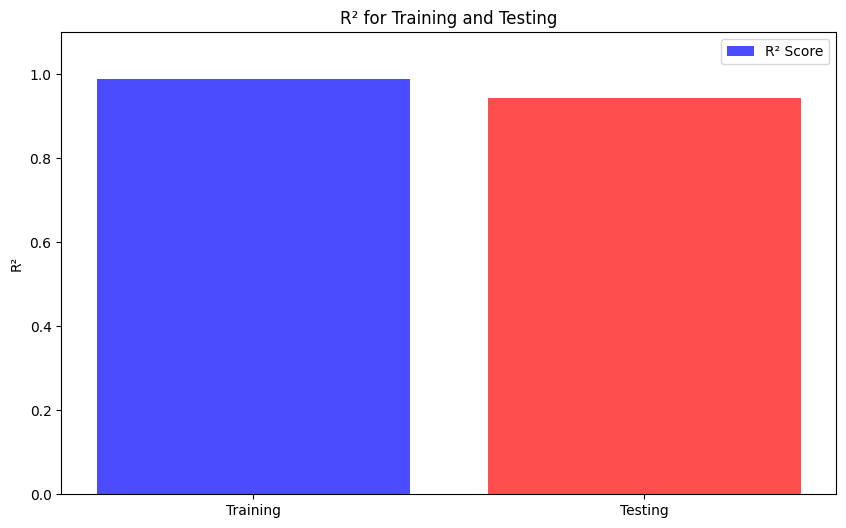

In [356]:
train_and_plot_tree_based_model_r2_comparison(model=bgr,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

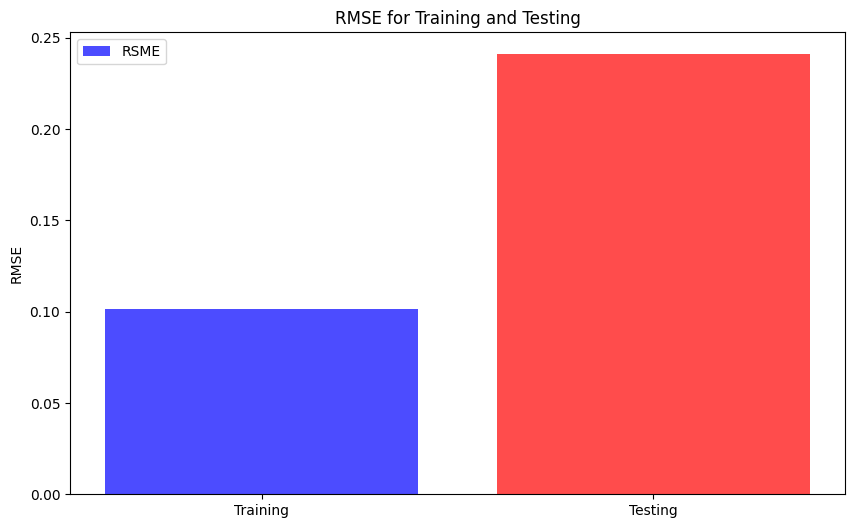

In [357]:
train_and_plot_tree_based_model_rmse_comparison(model=bgr,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

In [358]:
model_performance_report(model_name="Bagging Regression with box-cox transformation on target variable", 
                         model=bgr, X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

Mean Squared Error  0.010318689949996115
Root Mean Squared Error  0.10158095269289472
Mean Absolute Error  0.044995074555151615
Mean Absolute Percentage Error  0.14041207165209427
R2 score  0.9896813100500039
Adjusted R2 score  0.9896458798551475
Mean Squared Error  0.058067889143693416
Root Mean Squared Error  0.24097279751808795
Mean Absolute Error  0.1270381284383898
Mean Absolute Percentage Error  0.3859088103295102
R2 score  0.9419321108563066
Adjusted R2 score  0.9411260602018966


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [359]:
# Bagging regression model is performance is decently good but not the best.

In [360]:
%%time
hgbr = HistGradientBoostingRegressor()
hgbr.fit(X_train,y_train_transformed)
print("Training performance: ")
print(model_performance(hgbr,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(hgbr,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.025209850694869675
Root Mean Squared Error  0.15877610240483192
Mean Absolute Error  0.08358786390412581
Mean Absolute Percentage Error  0.3135284871192014
R2 score  0.9747901493051303
Adjusted R2 score  0.9747035889058209
None

Testing performance: 
Mean Squared Error  0.05182097197903495
Root Mean Squared Error  0.2276422016653216
Mean Absolute Error  0.12029774952524928
Mean Absolute Percentage Error  0.37772823110960574
R2 score  0.9481790280209651
Adjusted R2 score  0.9474596919301956
None
CPU times: total: 1.59 s
Wall time: 264 ms


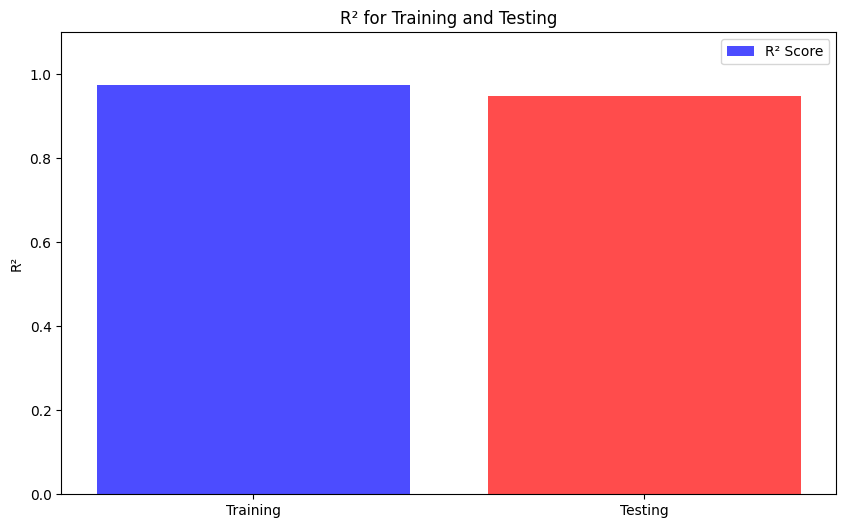

In [361]:
train_and_plot_tree_based_model_r2_comparison(model=hgbr,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

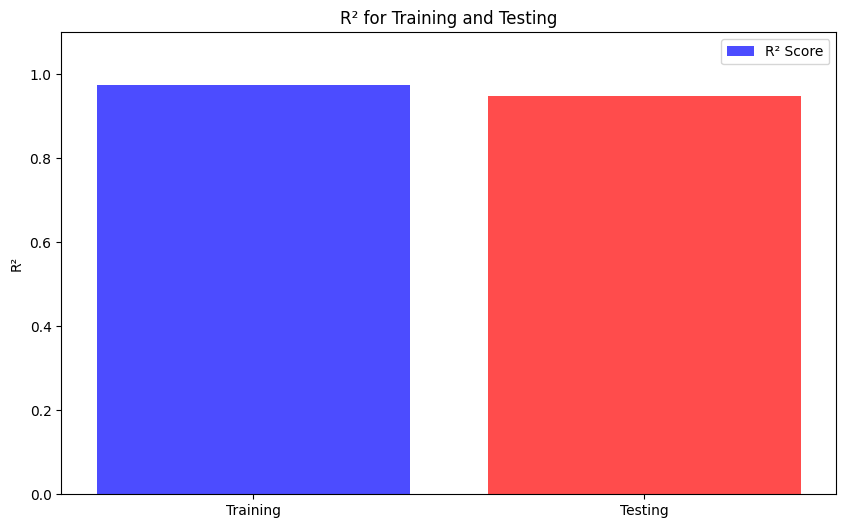

In [362]:
train_and_plot_tree_based_model_r2_comparison(model=hgbr,X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

In [363]:
model_performance_report(model_name="HistGradient Boosting Regression with box-cox transformation on target variable", 
                         model=hgbr, X_train=X_train,y_train=y_train_transformed,
                        X_test=X_test, y_test=y_test_transformed)

Mean Squared Error  0.025209850694869675
Root Mean Squared Error  0.15877610240483192
Mean Absolute Error  0.08358786390412581
Mean Absolute Percentage Error  0.3135284871192014
R2 score  0.9747901493051303
Adjusted R2 score  0.9747035889058209
Mean Squared Error  0.05182097197903495
Root Mean Squared Error  0.2276422016653216
Mean Absolute Error  0.12029774952524928
Mean Absolute Percentage Error  0.37772823110960574
R2 score  0.9481790280209651
Adjusted R2 score  0.9474596919301956


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [364]:
%%time
mlp = MLPRegressor()
mlp.fit(X_train_with_scaling,y_train_transformed)
print("Training performance: ")
print(model_performance(mlp,X_train_with_scaling, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(mlp,X_test_with_scaling, y_test_transformed))

Training performance: 
Mean Squared Error  0.04571547073905479
Root Mean Squared Error  0.21381176473490598
Mean Absolute Error  0.13948297971586626
Mean Absolute Percentage Error  0.8225618700296065
R2 score  0.9542845292609452
Adjusted R2 score  0.9541275608818109
None

Testing performance: 
Mean Squared Error  0.0628811890297743
Root Mean Squared Error  0.25076121915035887
Mean Absolute Error  0.1601804228918439
Mean Absolute Percentage Error  0.7699441709376789
R2 score  0.9371188109702258
Adjusted R2 score  0.9362459460475471
None
CPU times: total: 21.3 s
Wall time: 3.49 s


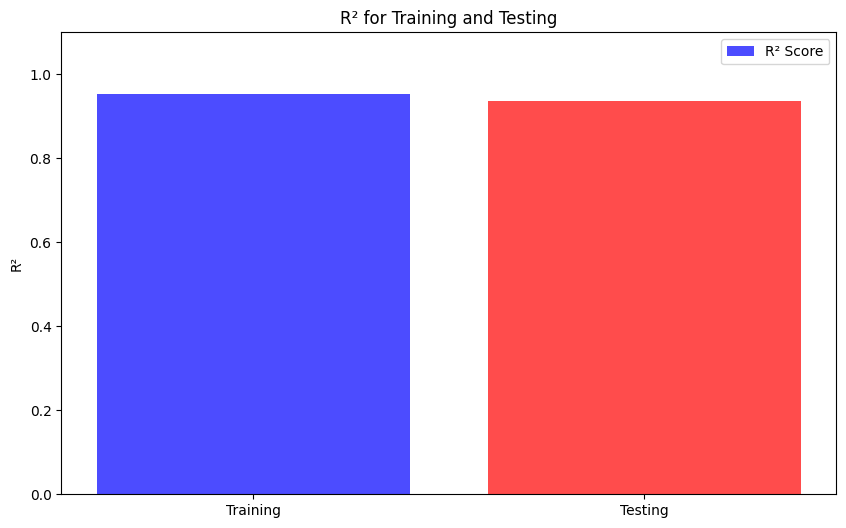

In [365]:
train_and_plot_tree_based_model_r2_comparison(model=mlp,X_train=X_train_with_scaling,y_train=y_train_transformed,
                        X_test=X_test_with_scaling, y_test=y_test_transformed)

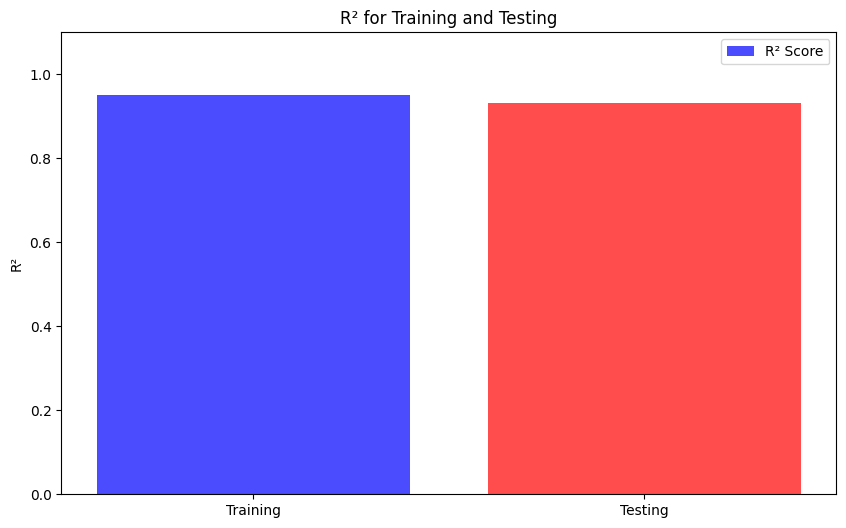

In [366]:
train_and_plot_tree_based_model_r2_comparison(model=mlp,X_train=X_train_with_scaling,y_train=y_train_transformed,
                        X_test=X_test_with_scaling, y_test=y_test_transformed)

In [367]:
model_performance_report(model_name="MLP Regression with box-cox transformation on target variable", 
                         model=mlp, X_train=X_train_with_scaling,y_train=y_train_transformed,
                        X_test=X_test_with_scaling, y_test=y_test_transformed)

Mean Squared Error  0.04967311211311613
Root Mean Squared Error  0.22287465560964112
Mean Absolute Error  0.15790017014585406
Mean Absolute Percentage Error  0.7132185587224487
R2 score  0.9503268878868839
Adjusted R2 score  0.9501563305729397
Mean Squared Error  0.0678311031450275
Root Mean Squared Error  0.26044404993208714
Mean Absolute Error  0.17613651285774423
Mean Absolute Percentage Error  0.9560857398435891
R2 score  0.9321688968549725
Adjusted R2 score  0.9312273212977122


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [368]:
# We able to bring the gap between train and test performance much closer.

# Stacking 

In [369]:
%%time
base_models = [
    ('random_forest', RandomForestRegressor()),
    ('gradient_boosting', GradientBoostingRegressor())
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.013493058329240038
Root Mean Squared Error  0.11615962435046025
Mean Absolute Error  0.06280477221835862
Mean Absolute Percentage Error  0.3176682215605335
R2 score  0.9865069416707599
Adjusted R2 score  0.9864606119827732
None

Testing performance: 
Mean Squared Error  0.051319628255041355
Root Mean Squared Error  0.22653835934569969
Mean Absolute Error  0.12093280481846425
Mean Absolute Percentage Error  0.3780220392594525
R2 score  0.9486803717449587
Adjusted R2 score  0.9479679948952219
None
CPU times: total: 27.1 s
Wall time: 25.5 s


In [370]:
%%time
base_models = [
    ('random_forest', RandomForestRegressor()),
    ('gradient_boosting', GradientBoostingRegressor()),
    ('Decision_Tree', DecisionTreeRegressor()),
    ('Bagging_Regressor', BaggingRegressor())
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.015123998439207434
Root Mean Squared Error  0.12297966677141157
Mean Absolute Error  0.06668952019574884
Mean Absolute Percentage Error  0.33516717549735836
R2 score  0.9848760015607926
Adjusted R2 score  0.9848240718861627
None

Testing performance: 
Mean Squared Error  0.05115886268772251
Root Mean Squared Error  0.2261832502368876
Mean Absolute Error  0.12208802168693095
Mean Absolute Percentage Error  0.3773018043360412
R2 score  0.9488411373122775
Adjusted R2 score  0.948130992077856
None
CPU times: total: 28.6 s
Wall time: 27.6 s


In [371]:
%%time
base_models = [
    ('random_forest', RandomForestRegressor()),
    ('gradient_boosting', GradientBoostingRegressor()),
    ('Decision_Tree', DecisionTreeRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor())
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.01408664329075283
Root Mean Squared Error  0.11868716565304283
Mean Absolute Error  0.06335764078775451
Mean Absolute Percentage Error  0.31272252031611847
R2 score  0.9859133567092472
Adjusted R2 score  0.9858649888913281
None

Testing performance: 
Mean Squared Error  0.050281001808930026
Root Mean Squared Error  0.22423425654642964
Mean Absolute Error  0.12024316222692841
Mean Absolute Percentage Error  0.3690608056323154
R2 score  0.94971899819107
Adjusted R2 score  0.9490210386989971
None
CPU times: total: 38.1 s
Wall time: 29.1 s


In [372]:
(0.9821648659325758 - 0.9460590876359604)*100

3.610577829661543

In [373]:
%%time
base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('XG_boosting', XGBRegressor())
]


meta_model = Lasso(alpha=0.05)

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.015044182354270548
Root Mean Squared Error  0.1226547282181594
Mean Absolute Error  0.07585278822268716
Mean Absolute Percentage Error  0.20609601896981425
R2 score  0.9849558176457295
Adjusted R2 score  0.9849041620271528
None

Testing performance: 
Mean Squared Error  0.05425801873733824
Root Mean Squared Error  0.2329335071159541
Mean Absolute Error  0.1305658014040409
Mean Absolute Percentage Error  0.4710153891742755
R2 score  0.9457419812626617
Adjusted R2 score  0.9449888160941812
None
CPU times: total: 48.1 s
Wall time: 30.1 s


In [374]:
(0.9840451954096037 - 0.9491670754451513)*100

3.4878119964452337

In [375]:
%%time
base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('XG_boosting', XGBRegressor())
]


meta_model = Lasso(alpha=0.01)

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.013309169872174573
Root Mean Squared Error  0.11536537553431954
Mean Absolute Error  0.0602128388197654
Mean Absolute Percentage Error  0.14990791717300372
R2 score  0.9866908301278254
Adjusted R2 score  0.9866451318381942
None

Testing performance: 
Mean Squared Error  0.05082200047843361
Root Mean Squared Error  0.22543735377801438
Mean Absolute Error  0.12058092409143228
Mean Absolute Percentage Error  0.3637600736413247
R2 score  0.9491779995215665
Adjusted R2 score  0.9484725303311384
None
CPU times: total: 48.3 s
Wall time: 29.9 s


In [376]:
(0.9806549287610352 - 0.9422613335687958)*100

3.8393595192239394

In [377]:
%%time
base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('XG_boosting', XGBRegressor())
]


meta_model = Lasso(alpha=0.075)

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.020159780569558375
Root Mean Squared Error  0.1419851420732408
Mean Absolute Error  0.09246369361931088
Mean Absolute Percentage Error  0.26884919679027425
R2 score  0.9798402194304416
Adjusted R2 score  0.979770998923061
None

Testing performance: 
Mean Squared Error  0.05852109410515844
Root Mean Squared Error  0.24191133521428557
Mean Absolute Error  0.14332294259524853
Mean Absolute Percentage Error  0.5407408659963681
R2 score  0.9414789058948416
Adjusted R2 score  0.9406665642220882
None
CPU times: total: 47.9 s
Wall time: 30 s


In [378]:
%%time
base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('XG_boosting', XGBRegressor())
]


meta_model = Lasso(alpha=0.005)

kf = KFold(n_splits=3, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.014374985687130576
Root Mean Squared Error  0.1198957283940115
Mean Absolute Error  0.06130316601800878
Mean Absolute Percentage Error  0.20978273222725066
R2 score  0.9856250143128694
Adjusted R2 score  0.9855756564441456
None

Testing performance: 
Mean Squared Error  0.050515325203369425
Root Mean Squared Error  0.2247561460858622
Mean Absolute Error  0.11961404023034218
Mean Absolute Percentage Error  0.37249593524649666
R2 score  0.9494846747966306
Adjusted R2 score  0.9487834626200152
None
CPU times: total: 31.3 s
Wall time: 18.1 s


In [379]:
%%time
base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('XG_boosting', XGBRegressor())
]


meta_model = Lasso(alpha=0.0075)

kf = KFold(n_splits=3, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.01632682760014364
Root Mean Squared Error  0.12777647514368065
Mean Absolute Error  0.06568162775588357
Mean Absolute Percentage Error  0.22430917140091974
R2 score  0.9836731723998564
Adjusted R2 score  0.9836171126978919
None

Testing performance: 
Mean Squared Error  0.05098408762412809
Root Mean Squared Error  0.22579656247190322
Mean Absolute Error  0.1194673114502782
Mean Absolute Percentage Error  0.4054177595574503
R2 score  0.9490159123758719
Adjusted R2 score  0.948308193225065
None
CPU times: total: 31.3 s
Wall time: 18.1 s


In [380]:
%%time
base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('XG_boosting', XGBRegressor())
]


meta_model = Lasso(alpha=0.00075)

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.015418037643146414
Root Mean Squared Error  0.1241693909268561
Mean Absolute Error  0.06620327695167136
Mean Absolute Percentage Error  0.2886037915585409
R2 score  0.9845819623568536
Adjusted R2 score  0.9845290230708931
None

Testing performance: 
Mean Squared Error  0.050618819725428255
Root Mean Squared Error  0.2249862656373234
Mean Absolute Error  0.12129821844846388
Mean Absolute Percentage Error  0.3751058030484925
R2 score  0.9493811802745717
Adjusted R2 score  0.9486785314721644
None
CPU times: total: 48 s
Wall time: 29.8 s


In [381]:
%%time
base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('XG_boosting', XGBRegressor())
]


meta_model = Lasso(alpha=0.00075)

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_transformed))

Training performance: 
Mean Squared Error  0.013410939677913106
Root Mean Squared Error  0.11580561159940872
Mean Absolute Error  0.06166403316918044
Mean Absolute Percentage Error  0.2448935228736767
R2 score  0.9865890603220869
Adjusted R2 score  0.9865430125962322
None

Testing performance: 
Mean Squared Error  0.050221729655585017
Root Mean Squared Error  0.22410205187723073
Mean Absolute Error  0.12109389075043497
Mean Absolute Percentage Error  0.3317560475793736
R2 score  0.949778270344415
Adjusted R2 score  0.9490811336196012
None
CPU times: total: 47.9 s
Wall time: 29.7 s


In [382]:
%%time

X_signi_columns_new = ['Number of Policies', 'Monthly Premium Auto']
#X_signi_columns[:-21]
print(X_signi_columns_new)


base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor()),
    ('Bagging_Regressor', BaggingRegressor()),
    ('Hist_gradient_boosting', HistGradientBoostingRegressor()),
    ('XG_boosting', XGBRegressor())
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train[X_signi_columns_new], y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train[X_signi_columns_new], y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test[X_signi_columns_new], y_test_transformed))

['Number of Policies', 'Monthly Premium Auto']
Training performance: 
Mean Squared Error  0.0631094940652911
Root Mean Squared Error  0.25121603066940434
Mean Absolute Error  0.1648615972589437
Mean Absolute Percentage Error  0.7007383446665988
R2 score  0.9368905059347089
Adjusted R2 score  0.9368732251312957
None

Testing performance: 
Mean Squared Error  0.0639545204522545
Root Mean Squared Error  0.25289230999034845
Mean Absolute Error  0.17296485380515988
Mean Absolute Percentage Error  0.8319991808501502
R2 score  0.9360454795477455
Adjusted R2 score  0.9359753539770742
None
CPU times: total: 17 s
Wall time: 4.54 s


In [383]:
%%time

X_signi_columns_new = ['Number of Policies', 'Monthly Premium Auto','Response']
#X_signi_columns[:-21]
print(X_signi_columns_new)


base_models = [
    ('Random_forest', RandomForestRegressor(max_depth=8)),
    ('Gradient_boosting', GradientBoostingRegressor(learning_rate=0.1,n_estimators=100, max_depth=2))
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train[X_signi_columns_new], y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train[X_signi_columns_new], y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test[X_signi_columns_new], y_test_transformed))

['Number of Policies', 'Monthly Premium Auto', 'Response']
Training performance: 
Mean Squared Error  0.06056926848039626
Root Mean Squared Error  0.2461082454538983
Mean Absolute Error  0.16076131275034525
Mean Absolute Percentage Error  0.62036533520996
R2 score  0.9394307315196038
Adjusted R2 score  0.9394058502645797
None

Testing performance: 
Mean Squared Error  0.061539875872905526
Root Mean Squared Error  0.24807231984424527
Mean Absolute Error  0.16788743310043772
Mean Absolute Percentage Error  0.8297913116038973
R2 score  0.9384601241270945
Adjusted R2 score  0.9383588517038258
None
CPU times: total: 3.8 s
Wall time: 2.44 s
Compiler : 141 ms


In [384]:
%%time

X_signi_columns_new = X_signi_columns[:-18]
print(X_signi_columns_new)


base_models = [
    ('Random_forest', RandomForestRegressor(max_depth=7, max_features='sqrt' ,oob_score=True)),
    ('Gradient_boosting', GradientBoostingRegressor(learning_rate=0.05,n_estimators=200, max_depth=2))
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train[X_signi_columns_new], y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train[X_signi_columns_new], y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test[X_signi_columns_new], y_test_transformed))

['Number of Policies', 'Monthly Premium Auto', 'Response', 'EmploymentStatus', 'Vehicle Class', 'Number of Open Complaints', 'Renew Offer Type']
Training performance: 
Mean Squared Error  0.05771096194349673
Root Mean Squared Error  0.24023105948960208
Mean Absolute Error  0.1389900823874476
Mean Absolute Percentage Error  0.550166250741924
R2 score  0.9422890380565033
Adjusted R2 score  0.9422336911961657
None

Testing performance: 
Mean Squared Error  0.056948633087636175
Root Mean Squared Error  0.2386391273191305
Mean Absolute Error  0.14164183609667097
Mean Absolute Percentage Error  0.41622098618542386
R2 score  0.9430513669123638
Adjusted R2 score  0.9428322132941046
None
CPU times: total: 4.8 s
Wall time: 3.7 s


In [385]:
%%time

X_signi_columns_new = X_signi_columns[:-18]
print(X_signi_columns_new)


base_models = [
    ('Random_forest', RandomForestRegressor(max_depth=7, max_features='sqrt' ,oob_score=True)),
    ('Gradient_boosting', GradientBoostingRegressor(learning_rate=0.05,n_estimators=200, max_depth=3))
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train[X_signi_columns_new], y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train[X_signi_columns_new], y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test[X_signi_columns_new], y_test_transformed))

['Number of Policies', 'Monthly Premium Auto', 'Response', 'EmploymentStatus', 'Vehicle Class', 'Number of Open Complaints', 'Renew Offer Type']
Training performance: 
Mean Squared Error  0.05566062522581083
Root Mean Squared Error  0.2359250415403393
Mean Absolute Error  0.13254621830017177
Mean Absolute Percentage Error  0.5444921432616228
R2 score  0.9443393747741892
Adjusted R2 score  0.9442859942595185
None

Testing performance: 
Mean Squared Error  0.05559581132230517
Root Mean Squared Error  0.23578764030861576
Mean Absolute Error  0.13685761147312972
Mean Absolute Percentage Error  0.4902643612399212
R2 score  0.9444041886776948
Adjusted R2 score  0.9441902410805226
None
CPU times: total: 5.41 s
Wall time: 4.38 s


In [386]:
%%time

X_signi_columns_new = X_signi_columns[:-18]
print(X_signi_columns_new)


base_models = [
    ('Random_forest', RandomForestRegressor(max_depth=7, max_features='sqrt' ,oob_score=True)),
    ('Gradient_boosting', GradientBoostingRegressor(learning_rate=0.05,n_estimators=200, max_depth=3))
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train[X_signi_columns_new], y_train_transformed)

print("Training performance: ")
print(model_performance(stacking_model,X_train[X_signi_columns_new], y_train_transformed))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test[X_signi_columns_new], y_test_transformed))

['Number of Policies', 'Monthly Premium Auto', 'Response', 'EmploymentStatus', 'Vehicle Class', 'Number of Open Complaints', 'Renew Offer Type']
Training performance: 
Mean Squared Error  0.05558203220414901
Root Mean Squared Error  0.23575841915857215
Mean Absolute Error  0.1323970257944981
Mean Absolute Percentage Error  0.527785870711233
R2 score  0.944417967795851
Adjusted R2 score  0.944364662654677
None

Testing performance: 
Mean Squared Error  0.05558403362347862
Root Mean Squared Error  0.23576266376056795
Mean Absolute Error  0.13621461713946276
Mean Absolute Percentage Error  0.48477519968286026
R2 score  0.9444159663765214
Adjusted R2 score  0.944202064103094
None
CPU times: total: 5.5 s
Wall time: 4.52 s


In [387]:
model_performance_report(model_name="Stacking Regression with box-cox transformation on target variable", 
                         model=stacking_model, X_train=X_train[X_signi_columns_new],y_train=y_train_transformed,
                        X_test=X_test[X_signi_columns_new], y_test=y_test_transformed)

Mean Squared Error  0.05558203220414901
Root Mean Squared Error  0.23575841915857215
Mean Absolute Error  0.1323970257944981
Mean Absolute Percentage Error  0.527785870711233
R2 score  0.944417967795851
Adjusted R2 score  0.944364662654677
Mean Squared Error  0.05558403362347862
Root Mean Squared Error  0.23576266376056795
Mean Absolute Error  0.13621461713946276
Mean Absolute Percentage Error  0.48477519968286026
R2 score  0.9444159663765214
Adjusted R2 score  0.944202064103094


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


# Other Transformation

In [388]:
y_train.skew()

3.0373240190627677

In [389]:
y_test.skew()

3.0078443858040127

In [390]:
y_train_rec = 1/y_train
y_test_rec = 1/y_test

In [391]:
y_train_rec.skew()

0.7068853908886816

In [392]:
y_test_rec.skew()

0.6509895141243633

In [393]:
%%time
dt=DecisionTreeRegressor()
dt.fit(X_train,y_train_rec)
print("Training performance: ")
print(model_performance(dt,X_train, y_train_rec))
print()
print("Testing performance: ")
print(model_performance(dt,X_test, y_test_rec))

Training performance: 
Mean Squared Error  3.338234227717126e-18
Root Mean Squared Error  1.8270835305801227e-09
Mean Absolute Error  2.942624452911155e-10
Mean Absolute Percentage Error  2.0928432966659547e-06
R2 score  0.999999999725529
Adjusted R2 score  0.9999999997245865
None

Testing performance: 
Mean Squared Error  4.2333015388455443e-10
Root Mean Squared Error  2.0574988551261808e-05
Mean Absolute Error  1.0286361490947845e-05
Mean Absolute Percentage Error  0.11584182785832955
R2 score  0.9649263949605018
Adjusted R2 score  0.9644395320365776
None
CPU times: total: 62.5 ms
Wall time: 74 ms


In [394]:
%%time
rf=RandomForestRegressor()
rf.fit(X_train,y_train_rec)
print("Training performance: ")
print(model_performance(rf,X_train, y_train_rec))
print()
print("Testing performance: ")
print(model_performance(rf,X_test, y_test_rec))

Training performance: 
Mean Squared Error  3.038459937787125e-11
Root Mean Squared Error  5.512222725713399e-06
Mean Absolute Error  3.041308399341029e-06
Mean Absolute Percentage Error  0.03785116771730357
R2 score  0.9975017655552637
Adjusted R2 score  0.9974931876317479
None

Testing performance: 
Mean Squared Error  2.1802700661282339e-10
Root Mean Squared Error  1.4765737591221895e-05
Mean Absolute Error  8.269592579205618e-06
Mean Absolute Percentage Error  0.10089940839386034
R2 score  0.9819361010603378
Adjusted R2 score  0.9816853528796096
None
CPU times: total: 4.11 s
Wall time: 4.12 s


In [395]:
# we able to improve the model performance significant from 94% to 98%

In [396]:
model_performance_report(model_name="Random Forest Regression with reciprocal transformation on target variable", 
                         model=rf, X_train=X_train,y_train=y_train_rec,
                        X_test=X_test, y_test=y_test_rec)

Mean Squared Error  3.038459937787125e-11
Root Mean Squared Error  5.512222725713399e-06
Mean Absolute Error  3.041308399341029e-06
Mean Absolute Percentage Error  0.03785116771730357
R2 score  0.9975017655552637
Adjusted R2 score  0.9974931876317479
Mean Squared Error  2.1802700661282339e-10
Root Mean Squared Error  1.4765737591221895e-05
Mean Absolute Error  8.269592579205618e-06
Mean Absolute Percentage Error  0.10089940839386034
R2 score  0.9819361010603378
Adjusted R2 score  0.9816853528796096


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


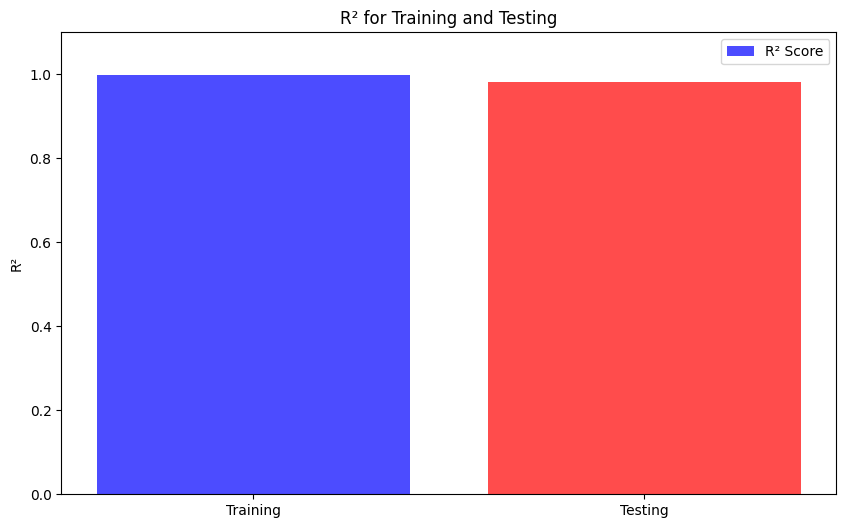

In [397]:
train_and_plot_tree_based_model_r2_comparison(model=rf,X_train=X_train,y_train=y_train_rec,
                        X_test=X_test, y_test=y_test_rec)

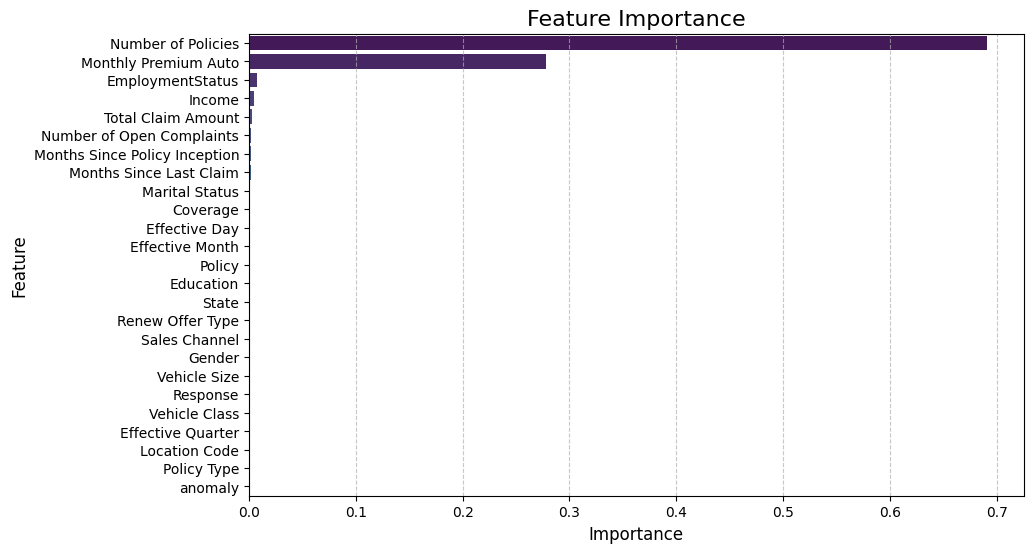

In [398]:
get_feature_importance_with_plot(model=rf, feature_names=X_train.columns)

In [399]:
%%time
gbr=GradientBoostingRegressor()
gbr.fit(X_train,y_train_rec)
print("Training performance: ")
print(model_performance(gbr,X_train, y_train_rec))
print()
print("Testing performance: ")
print(model_performance(gbr,X_test, y_test_rec))

Training performance: 
Mean Squared Error  2.1122203208931786e-10
Root Mean Squared Error  1.4533479696525464e-05
Mean Absolute Error  8.817321481302712e-06
Mean Absolute Percentage Error  0.11414392827802343
R2 score  0.9826332363481137
Adjusted R2 score  0.9825736059276636
None

Testing performance: 
Mean Squared Error  2.292936901611671e-10
Root Mean Squared Error  1.5142446637223693e-05
Mean Absolute Error  9.247515532111324e-06
Mean Absolute Percentage Error  0.11537284984960625
R2 score  0.9810026376506243
Adjusted R2 score  0.9807389318989672
None
CPU times: total: 1.11 s
Wall time: 1.11 s


In [400]:
model_performance_report(model_name="Gradient Boosting Regression with reciprocal transformation on target variable", 
                         model=gbr, X_train=X_train,y_train=y_train_rec,
                        X_test=X_test, y_test=y_test_rec)

Mean Squared Error  2.1122203208931786e-10
Root Mean Squared Error  1.4533479696525464e-05
Mean Absolute Error  8.817321481302712e-06
Mean Absolute Percentage Error  0.11414392827802343
R2 score  0.9826332363481137
Adjusted R2 score  0.9825736059276636
Mean Squared Error  2.292936901611671e-10
Root Mean Squared Error  1.5142446637223693e-05
Mean Absolute Error  9.247515532111324e-06
Mean Absolute Percentage Error  0.11537284984960625
R2 score  0.9810026376506243
Adjusted R2 score  0.9807389318989672


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


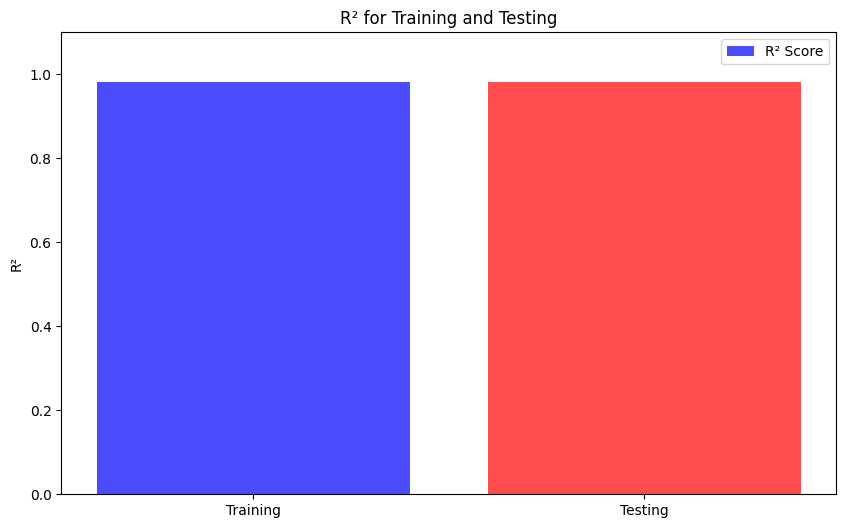

In [401]:
train_and_plot_tree_based_model_r2_comparison(model=gbr,X_train=X_train,y_train=y_train_rec,
                        X_test=X_test, y_test=y_test_rec)

In [402]:
%%time
xgbr=XGBRegressor()
xgbr.fit(X_train,y_train_rec)
print("Training performance: ")
print(model_performance(xgbr,X_train, y_train_rec))
print()
print("Testing performance: ")
print(model_performance(xgbr,X_test, y_test_rec))

Training performance: 
Mean Squared Error  8.649136681790156e-10
Root Mean Squared Error  2.940941461809493e-05
Mean Absolute Error  2.06710234191796e-05
Mean Absolute Percentage Error  0.2295044383282741
R2 score  0.9288864371487572
Adjusted R2 score  0.9286422620256586
None

Testing performance: 
Mean Squared Error  8.355831582311488e-10
Root Mean Squared Error  2.8906455303809717e-05
Mean Absolute Error  2.04606831357683e-05
Mean Absolute Percentage Error  0.22097892684627343
R2 score  0.9307705501237502
Adjusted R2 score  0.9298095638678333
None
CPU times: total: 484 ms
Wall time: 59 ms


In [403]:
model_performance_report(model_name="Xtreme Gradient Boosting Regression with reciprocal transformation on target variable", 
                         model=xgbr, X_train=X_train,y_train=y_train_rec,
                        X_test=X_test, y_test=y_test_rec)

Mean Squared Error  8.649136681790156e-10
Root Mean Squared Error  2.940941461809493e-05
Mean Absolute Error  2.06710234191796e-05
Mean Absolute Percentage Error  0.2295044383282741
R2 score  0.9288864371487572
Adjusted R2 score  0.9286422620256586
Mean Squared Error  8.355831582311488e-10
Root Mean Squared Error  2.8906455303809717e-05
Mean Absolute Error  2.04606831357683e-05
Mean Absolute Percentage Error  0.22097892684627343
R2 score  0.9307705501237502
Adjusted R2 score  0.9298095638678333


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [404]:
%%time
lgbm=LGBMRegressor()
lgbm.fit(X_train,y_train_rec)
print("Training performance: ")
print(model_performance(lgbm,X_train, y_train_rec))
print()
print("Testing performance: ")
print(model_performance(lgbm,X_test, y_test_rec))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 7307, number of used features: 25
[LightGBM] [Info] Start training from score 0.000191
Training performance: 
Mean Squared Error  1.1361147931224717e-10
Root Mean Squared Error  1.0658868575615667e-05
Mean Absolute Error  6.217810638468851e-06
Mean Absolute Percentage Error  0.08171268737792729
R2 score  0.9906588167444453
Adjusted R2 score  0.99062674291099
None

Testing performance: 
Mean Squared Error  2.104620269215214e-10
Root Mean Squared Error  1.4507309430818708e-05
Mean Absolute Error  8.175759132269802e-06
Mean Absolute Percentage Error  0.10344680846337062
R2 score  0.9825628721688682


In [405]:
model_performance_report(model_name="Light Gradient Boosting Machine Regression with reciprocal transformation on target variable", 
                         model=lgbm, X_train=X_train,y_train=y_train_rec,
                        X_test=X_test, y_test=y_test_rec)

Mean Squared Error  1.1361147931224717e-10
Root Mean Squared Error  1.0658868575615667e-05
Mean Absolute Error  6.217810638468851e-06
Mean Absolute Percentage Error  0.08171268737792729
R2 score  0.9906588167444453
Adjusted R2 score  0.99062674291099
Mean Squared Error  2.104620269215214e-10
Root Mean Squared Error  1.4507309430818708e-05
Mean Absolute Error  8.175759132269802e-06
Mean Absolute Percentage Error  0.10344680846337062
R2 score  0.9825628721688682
Adjusted R2 score  0.9823208243089135


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [406]:
# Light GBM model is performing best among the other models while Gradient boosting is performing equally well on train and test data

In [407]:
%%time
bgr=BaggingRegressor()
bgr.fit(X_train,y_train_rec)
print("Training performance: ")
print(model_performance(bgr,X_train, y_train_rec))
print()
print("Testing performance: ")
print(model_performance(bgr,X_test, y_test_rec))

Training performance: 
Mean Squared Error  4.014597241294556e-11
Root Mean Squared Error  6.336084943634007e-06
Mean Absolute Error  3.2476623321198526e-06
Mean Absolute Percentage Error  0.039412395811207944
R2 score  0.9966991813894871
Adjusted R2 score  0.9966878477175652
None

Testing performance: 
Mean Squared Error  2.410868175015324e-10
Root Mean Squared Error  1.5526970647925253e-05
Mean Absolute Error  8.704851158693816e-06
Mean Absolute Percentage Error  0.10469672031916719
R2 score  0.9800255575000114
Adjusted R2 score  0.9797482887257195
None
CPU times: total: 766 ms
Wall time: 484 ms


In [408]:
%%time
hgbr=HistGradientBoostingRegressor()
hgbr.fit(X_train,y_train_rec)
print("Training performance: ")
print(model_performance(hgbr,X_train, y_train_rec))
print()
print("Testing performance: ")
print(model_performance(hgbr,X_test, y_test_rec))

Training performance: 
Mean Squared Error  1.0958919215296155e-10
Root Mean Squared Error  1.0468485666655018e-05
Mean Absolute Error  6.125001757544202e-06
Mean Absolute Percentage Error  0.0805885150883192
R2 score  0.990989530873764
Adjusted R2 score  0.9909585925784534
None

Testing performance: 
Mean Squared Error  2.160029473715974e-10
Root Mean Squared Error  1.4697038727975013e-05
Mean Absolute Error  8.176362601269901e-06
Mean Absolute Percentage Error  0.10398837428071898
R2 score  0.9821037977239274
Adjusted R2 score  0.9818553773702895
None
CPU times: total: 1.41 s
Wall time: 246 ms


In [409]:
%%time
base_models = [
    ('Random_forest', RandomForestRegressor()),
    ('Gradient_boosting', GradientBoostingRegressor())
]


meta_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model ,cv=kf, 
                                   passthrough=True, verbose=2)
stacking_model.fit(X_train, y_train_rec)

print("Training performance: ")
print(model_performance(stacking_model,X_train, y_train_rec))
print()
print("Testing performance: ")
print(model_performance(stacking_model,X_test, y_test_rec))

Training performance: 
Mean Squared Error  7.48362513125572e-11
Root Mean Squared Error  8.650794837039958e-06
Mean Absolute Error  5.213119253834975e-06
Mean Absolute Percentage Error  0.06685921607771039
R2 score  0.9938469321770905
Adjusted R2 score  0.9938258050385693
None

Testing performance: 
Mean Squared Error  2.0883414384009015e-10
Root Mean Squared Error  1.4451094901082414e-05
Mean Absolute Error  8.338728532935836e-06
Mean Absolute Percentage Error  0.10451337878376939
R2 score  0.9826977449808441
Adjusted R2 score  0.9824575693142816
None
CPU times: total: 26.3 s
Wall time: 25.1 s


In [410]:
 0.9948620056949374 - 0.9940860721760177

0.0007759335189196914

In [411]:
model_performance_report(model_name="Stacking Regression with reciprocal transformation on target variable", 
                         model=lgbm, X_train=X_train,y_train=y_train_rec,
                        X_test=X_test, y_test=y_test_rec)

Mean Squared Error  1.1361147931224717e-10
Root Mean Squared Error  1.0658868575615667e-05
Mean Absolute Error  6.217810638468851e-06
Mean Absolute Percentage Error  0.08171268737792729
R2 score  0.9906588167444453
Adjusted R2 score  0.99062674291099
Mean Squared Error  2.104620269215214e-10
Root Mean Squared Error  1.4507309430818708e-05
Mean Absolute Error  8.175759132269802e-06
Mean Absolute Percentage Error  0.10344680846337062
R2 score  0.9825628721688682
Adjusted R2 score  0.9823208243089135


,Model Name,Mse_train,Mse_test,Rmse_train,Rmse_test,Mae_train,Mae_test,Mape_train,Mape_test,R2_train,R2_test,R2_adj_train,R2_adj_test
0,Linear Regression,39927259.8142899,37619132.1617692,6318.8020870,6133.4437441,3916.5540444,3827.8658859,0.5972023,0.6015266,0.1640533,0.1630666,0.1611830,0.1514490
1,Ridge Regression aplha=0.1,39927285.7461664,37616900.6699754,6318.8041389,6133.2618296,3916.5821932,3827.6974147,0.5972651,0.6015651,0.1640527,0.1631163,0.1611824,0.1514993
2,Ridge Regression aplha=1,39929627.8381070,37599907.3877790,6318.9894634,6131.8763350,3916.9039741,3826.5388383,0.5978186,0.6019325,0.1640037,0.1634943,0.1611332,0.1518826
3,Lasso Regression,39928328.2255815,37603283.1278007,6318.8866286,6132.1515904,3915.8643188,3825.9975983,0.5974795,0.6018019,0.1640309,0.1634192,0.1611605,0.1518065
4,Decision Tree Regression,0.0000000,29753950.4821066,0.0000000,5454.7181854,0.0000000,1837.9148107,0.0000000,0.1373000,1.0000000,0.3380476,1.0000000,0.3288589
5,Random Forest Regression,1973750.1099494,14428428.0532479,1404.9021710,3798.4770703,546.0003011,1479.3433976,0.0394839,0.1092145,0.9586761,0.6790029,0.9585342,0.6745471
6,AdaBoost Regression,42365029.9233496,43842940.6853408,6508.8424411,6621.4002058,5496.9729846,5515.2191590,0.8299189,0.8269474,0.1130143,0.0246022,0.1099688,0.0110625
7,Gradient Boost Regression,12640404.4256935,14515707.6069971,3555.3346433,3809.9485045,1630.7787392,1710.3901855,0.1342121,0.1468476,0.7353511,0.6770611,0.7344424,0.6725784
8,Xtreme Gradient Boost Regression,30656729.5418267,29395859.0829144,5536.8519523,5421.7948212,3285.9866929,3261.7598234,0.5389796,0.5501316,0.3581480,0.3460143,0.3559441,0.3369362
9,Linear Regression with log transformation on t...,0.3216900,0.3141170,0.5671773,0.5604614,0.4396762,0.4365933,0.0495365,0.0493399,0.2477759,0.2527916,0.2451931,0.2424195


In [412]:
"""
model_performance_report_df = model_performance_report(model_name="Stacking Regression with reciprocal transformation on target variable", 
                         model=lgbm, X_train=X_train,y_train=y_train_rec,
                        X_test=X_test, y_test=y_test_rec)
model_performance_report_df.to_excel('Model_performance_Report.xlsx', index=False)
"""

Mean Squared Error  1.1361147931224717e-10
Root Mean Squared Error  1.0658868575615667e-05
Mean Absolute Error  6.217810638468851e-06
Mean Absolute Percentage Error  0.08171268737792729
R2 score  0.9906588167444453
Adjusted R2 score  0.99062674291099
Mean Squared Error  2.104620269215214e-10
Root Mean Squared Error  1.4507309430818708e-05
Mean Absolute Error  8.175759132269802e-06
Mean Absolute Percentage Error  0.10344680846337062
R2 score  0.9825628721688682
Adjusted R2 score  0.9823208243089135
